![Bigboi](https://upload.wikimedia.org/wikipedia/commons/6/69/IMDB_Logo_2016.svg)

Data can be created using `Wrangling.ipynb` or by putting `imdb.csv` (and `lemmatized_descriptions.csv`, if needed) in `./Data/Final/`

Csv files can be downloaded [here](https://drive.google.com/drive/folders/1bZeqhJixOjkc1wpm1zmz09-tyYrpTM3S?usp=sharing).

Introduction:

* Contexte du problème: facts and figures
* Objectifs
* Résultats principaux

Matériel et méthodes:
* Présentation des données
* Méthodes de Machine Learning utilisées
* Evaluation des modèles

Résultats:
* Statistiques descriptives
* Visualisation des données
* Résultats de performance des modèles

Discussion et conclusion:
* Résultats majeurs (meilleur modèle, performance)
* Pistes d'amélioration, perspectives

Limite 12 Juillet.

---
# Setup
---

In [1]:
# If it hasn't been done yet:
# Directories
for folder in ["Data", os.path.join("Data","Raw"), os.path.join("Data","Modified"), os.path.join("Data","Final"), os.path.join("API_key")]:
    if not os.path.isdir(folder):
        os.makedirs(folder)

# Don't forget to put the imdb.csv file in Data/Final/

In [2]:
##############################################################
# Dependencies

# System
import os
import psutil # This is just to get your number of cores; you can also just input it yourself, when needed

# Text
import string
import nltk

# Wrangling
import pandas as pd
pd.set_option('display.max_colwidth', 125)
import sks_functions as sks

# Stats
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.formula.api as sms
import statsmodels.api as sm

# Sklearn
## NLP
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

# Display
from IPython.core import display as ICD
## Progress bars! (super useful)
## https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations
import tqdm

# Graphs
import matplotlib.pyplot as plt
plt.style.use("dark_background")

import seaborn as sns
sns.set_style("ticks", {"ytick.left": False})
sns.set_context("notebook", font_scale=1.25)

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

# Text
import nltk
import gensim
## Stemmer/Lemmatizer
PorterStemmer = nltk.stem.PorterStemmer()
WordNetLemmatizer = nltk.stem.WordNetLemmatizer()

## Stop_words
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend([""])

###################################################################
# FUNCTIONS

## Get POS tags for WordNet

### This retrieves the part-of-speech tags from this webpage https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html 
### I put the equivalent tag for the WordNet lemmatizer in the "WordNetPOS" column, and then put all this in a dictionary.
WordNetPOSDict = pd.read_html("https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html")[0].iloc[1:,1:].rename(columns={1:"Tag", 2:"Name"}).assign(
    # First letter of the Penn Treebank Projct tab
    Tag_firstletter=lambda x: x["Tag"].str[0],
    # N* are nouns, V* are verbs, J* are adjectives, R* are adverbs. Other letters will be considered as nouns for WordNet.
    WordNetPOS=lambda x: np.select(
        condlist = [
            (x["Tag_firstletter"]=="N") | ~(x["Tag_firstletter"].isin(["N", "V", "J", "R"])),
            x["Tag_firstletter"]=="V",
            x["Tag_firstletter"]=="J",
            x["Tag_firstletter"]=="R",
        ],
        choicelist = 
        [
            nltk.corpus.wordnet.NOUN,
            nltk.corpus.wordnet.VERB, 
            nltk.corpus.wordnet.ADJ,
            nltk.corpus.wordnet.ADV
        ]
    )
).set_index("Tag").loc[:,"WordNetPOS"].to_dict()

### Alternative, if the website is down:
### WordNetPOSDict = {'CC': 'n', 'CD': 'n', 'DT': 'n', 'EX': 'n', 'FW': 'n', 'IN': 'n', 'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 'LS': 'n', 'MD': 'n', 'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n', 'PDT': 'n', 'POS': 'n', 'PRP': 'n', 'PRP$': 'n', 'RB': 'r', 'RBR': 'r', 'RBS': 'r', 'RP': 'r', 'SYM': 'n', 'TO': 'n', 'UH': 'n', 'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'WDT': 'n', 'WP': 'n', 'WP$': 'n', 'WRB': 'n'}
print("Penn Treebank part-of-speech tag ==> WordNet part-of-speech tag:\n", WordNetPOSDict, sep="")


def get_wordnet_pos(word, Penn_dictionary):
    '''
    Yields a POS tag for a word (i.e. if it is a verb, a noun...) to be used with WordNet Lemmatizer
    Initially inspired from: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
    But they use a if-else statement, which is not as good as a dictionary.

    Penn_dictionary must be a dictionnary. The key is the tag from the Penn Treebank Project, and the value must be its equivalent tag from nltk.corpus.wordnet (like nltk.corpus.wordnet.NOUN)
    '''
    return Penn_dictionary[nltk.tag.pos_tag([word])[0][1]]

## Twoway tables
## ! adapt this for sks_functions.py in the future
def twoway(data, rowvars, colvars, axis_percent=0):
    assert axis_percent in (0, 1), "axis_percent must be 0 (column) or 1 (row)"

    for colvar in colvars:
        print("Col variable: "+colvar)

        for rowvar in rowvars:
            crosstable = pd.crosstab(index=data[rowvar], columns=data[colvar])
            chi, p, dof, expected = stats.chi2_contingency(crosstable)
            
            print("Row variable: "+rowvar)
            ICD.display(
                pd.concat(
                    [data[rowvar].value_counts().rename("N"),
                    round(crosstable.apply(lambda x: x/x.sum(), axis=axis_percent)*100, 2)], axis = 1
                )
            )
            print("Chi2: ", round(chi, 4), "; P-value: ", round(p, 4), "\n", sep="")

Penn Treebank part-of-speech tag ==> WordNet part-of-speech tag:
{'CC': 'n', 'CD': 'n', 'DT': 'n', 'EX': 'n', 'FW': 'n', 'IN': 'n', 'JJ': 'a', 'JJR': 'a', 'JJS': 'a', 'LS': 'n', 'MD': 'n', 'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n', 'PDT': 'n', 'POS': 'n', 'PRP': 'n', 'PRP$': 'n', 'RB': 'r', 'RBR': 'r', 'RBS': 'r', 'RP': 'r', 'SYM': 'n', 'TO': 'n', 'UH': 'n', 'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'WDT': 'n', 'WP': 'n', 'WP$': 'n', 'WRB': 'n'}


## Plotly renderer

<span style="color:red">**Don't skip this if you want interactive graphs**</span>.

I keep plotly figures as SVG files for Github. Replace "svg" by "notebook" for interactive plots.

In [3]:
plotly_renderer = "svg"
# plotly_renderer = "notebook"

## Dataframe

I'll keep two separate dataframes: a full dataframe in which I won't drop empty plot descriptions, and another one without missing descriptions.

In [4]:
###########################################
# Import data

df = (
    pd.read_csv(os.path.join("Data", "Final", "imdb.csv"), low_memory=False, dtype={'mainstream':'category', "awards_nom_or_won":"category", "awards_won":"category"})
    .drop(columns=["Unnamed: 0"])
)

###########################################
# Missing values
print("Missing values:")
display(pd.concat(
    [
        df.isna().sum().rename("N"),
        round(((df.isna().sum() / len(df)) * 100).rename("%"), 2),
    ],
    axis=1,
).sort_values("%", ascending=False))

# List of columns to include in dropna
NaN_mask = ["startYear", "avgRating_crew", "sumVotes_crew", "genres"]
print("NaNs were dropped in those columns:", NaN_mask)

# I won't drop the NaN in the avgRating_weighted_* columns, since this would also drop usable observations in the avgRating_crew column
print("Length of df without NaN:",len(df.dropna(subset=NaN_mask)))
##% lost after deletion of NaNs
print(round((1-(len(df.dropna(subset=NaN_mask))/len(df)))*100, 2), "% lost", sep="")


# Delete NAs
df = df.dropna(subset=NaN_mask)

# Cleaning runtimeMinutes outliers
print("Cleaning runtimeMinutes (>300mn) + maxSeasons (>50) outliers:", len(df.loc[(df["runtimeMinutes"]>300) | (df["maxSeason"]>50)]), "observations deleted")
df = df.drop(df.loc[(df["runtimeMinutes"]>300) | (df["maxSeason"]>50)].index)

# Final df length
print("Final shape:", df.shape)

# List of columns
print("Columns:", [el for el in df.columns])

# To R, if needed.
# df.reset_index().to_feather(os.path.join("Data", "Final", "to_R.feather"))

##############################################################################################
# Df without missing plot descriptions
print("\n")
print("Df length (full):", len(df))
print(
    "Df length (with non-missing descriptions):",
    len(df.dropna(axis=0, how="any", subset=["plot"])),
)
print(
    "Films with non-missing descriptions:",
    round((len(df.dropna(axis=0, how="any", subset=["plot"])) / len(df)) * 100, 2),
    "%",
    sep="",
)

df_desc = df.dropna(axis=0, how="any", subset=["plot"])


Missing values:


,N,%
boxoffice,430463,95.87
production,399151,88.90
maxSeason,374961,83.51
awards,341765,76.12
rated,337344,75.13
plot,136845,30.48
names_Director,129157,28.77
names_Others,111131,24.75
avgRating_weighted_Others,111131,24.75
runtimeMinutes,82456,18.36


NaNs were dropped in those columns: ['startYear', 'avgRating_crew', 'sumVotes_crew', 'genres']
Length of df without NaN: 428874
4.48% lost
Cleaning runtimeMinutes (>300mn) + maxSeasons (>50) outliers: 1539 observations deleted
Final shape: (427335, 39)
Columns: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'runtimeMinutes', 'genres', 'changed_title', 'main_genre', 'averageRating', 'numVotes', 'n_titles', 'sumVotes_Actors', 'sumVotes_Director', 'sumVotes_Others', 'avgRating_weighted_Actors', 'avgRating_weighted_Director', 'avgRating_weighted_Others', 'maxSeason', 'crew_size_indice', 'sumVotes_crew', 'avgRating_crew', 'mainstream', 'log_numVotes', 'rated', 'awards', 'country', 'language', 'plot', 'boxoffice', 'production', 'names_Actors', 'names_Director', 'names_Others', 'Names', 'awards_nom_or_won', 'awards_won', 'all_texts']


Df length (full): 427335
Df length (with non-missing descriptions): 304421
Films with non-missing descriptions:71.24%


**Variables**

* `tconst`: ID
* `titleType`: type (movie, tvmovie, video)
* `primaryTitle`: known title
* `originalTitle`: original title
* `isAdult`: adult movie (binary)
* `startYear`: year
* `runtimeMinutes`: length of the movie
* `genres`: genres list
* `changed_title`: indicates whether `primaryTitle` != `originalTitle`
* `main_genre`: first element of the `genres` lists
* `averageRating`: averaging rating of the movie
* `numVotes`: number of votes
* `n_titles`: number of different titles for a movie
* `sumVotes_*`: sum of the votes of the main films the crew has worked on
* `avgRating_weighted_*`: weighted average of the film ratings the crew has worked on
* `maxSeason` : number of seasons (for series)
* `crew_size_indice`: number of "main" actors/directors/other crew in a film (it's NOT the number of people who has worked on a film; it's just the "main cast" on the IMDb page, I think)
* `mainstream`: 1 if the film is among the 15% percent of films with the most votes
* `rated`: MPAA ratingss
* `awards`: indicates the number of wins and/or nominations
* `awards_nom_or_won`: (binary) indicates if the film has won an award or has been nominated for one
* `awwards_won`: (binary) indicates if the film has won an award
* `country`: [place or places where the production companies for that title are based, and therefore where the financing originated](https://help.imdb.com/article/contribution/titles/countries/GTSW4DN8H8LKCXER#)
* `language`: original language of the movie
* `plot`: description of the plot
* `boxoffice`: box office (in $) 
* `production`: name of the production company
* `names_*`: crew names (by job)
* `Names`: all crew names
* `all_texts`: concatenation of genres, country, language, plot and Names

---
# Introduction
---
## Facts and figures

The number of new films has increased steadily over the years, since the early 20th century. The early 2000s saw an unprecedented increase in the number of new movies per year, peaking at 18,000 new films in 2017 alone. This is, unsurprisingly, a huge market for movie productions companies (Universal, Warner Bros...) and, recently, streaming media services (Netflix, Hulu, Amazon Prime Video). Movies (and other video content, in general) are, also unsurprisingly, very heterogeneous in their content: they differ in plots, tropes and artistic visions. They have nevertheless classifiable: some may tend to have similar [overarching themes](https://en.wikipedia.org/wiki/List_of_genres) and recurring [plot conventions and tropes](https://tvtropes.org/) (e.g. kids splitting up in horror movies), or simply similar actors or directors.

![Graph films](./img/figPPTX-Copy.svg)

Classifying movies in genres and subgenres is important in a situation where you have an abundance of content. For users, this notably allows to filter subjects and themes they know they don't like and, instead, find movies that will hopefully be to their taste. This is the idea behind recommendations systems. 

IMDb asserts being the "world's most popular and authoritative source for movies". It is indeed big, with information about 11 millions films/series/videos and their actors in its database. A lot of content can be retrieved from it (see above).

The dataset in this project can be used for numerous tasks:
* Predicting film ratings
* Predicting if a film will become "mainstream", or well-known (i.e. if it will be rated by at least a certain threshold of people)
* Predicting if a film will win an award
* Predicting the box office of a film (though data is scarce)
* Clustering movie descriptions
* Creating a recommendation system by finding similar movies 

## Objectives and results.

Here, I mainly focused on data exploration, visualisation, and on finding clusters of movie plots using KMeans, LSA and LDA. The goal was to, at the very least, find some common genres and themes using the plot description of each fillm. Each method managed to find a few very common themes (e.g. families, crimes, police, school, world wars, historical content, game shows), but the sheer variety of plot descriptions and possible themes in movies is difficult to reduce to just a dozen dimensions.

# Methodology

The database is presented in detail just above. In a nutshell: 

# Results

## Univariate

---
### Dependent variables (+ weights)
---

#### Average ratings (+ weights), awards

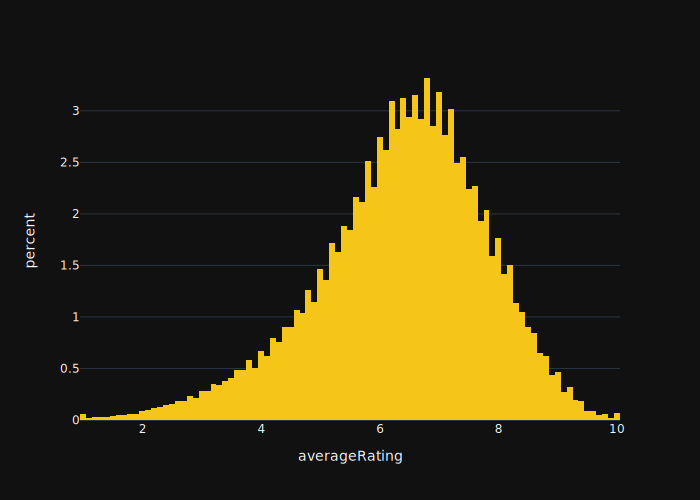

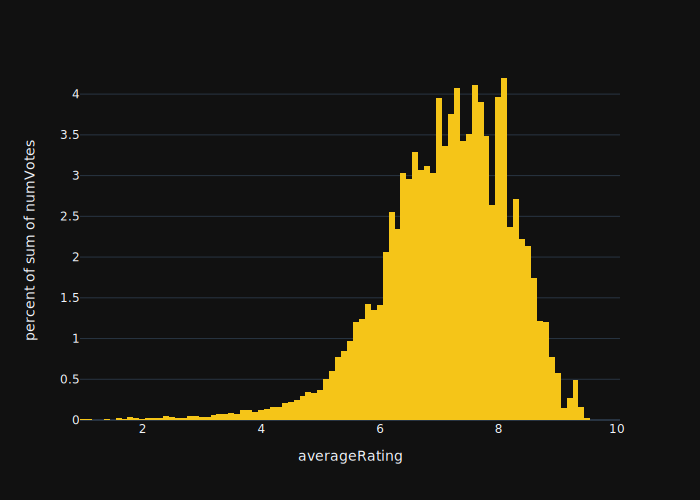

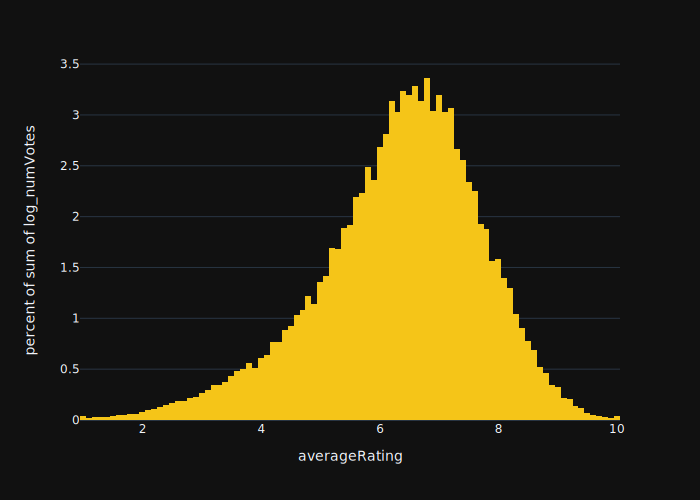

In [5]:
fig = px.histogram(df, x="averageRating", opacity=1, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Weights = numVotes

fig = px.histogram(df, x="averageRating", y="numVotes", histfunc='sum', opacity=1, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Weights = log_numVotes
# Bof. Pas très utile finalement, je pense.
fig = px.histogram(df, x="averageRating", y="log_numVotes", histfunc='sum', opacity=1, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

#### Weight/Number of votes per film

Unsurprinsingly, there's a huge amount of films with only a few votes. 85% of films have less than 500 votes. It's HEAVILY skewed right. In my opinion, that's a reason to use numVotes as a weight variables for a few analysis. Movies with a lot more votes should be heavily weighted since, arguably, the more votes your movie get, the closer it approaches its "true" rating.

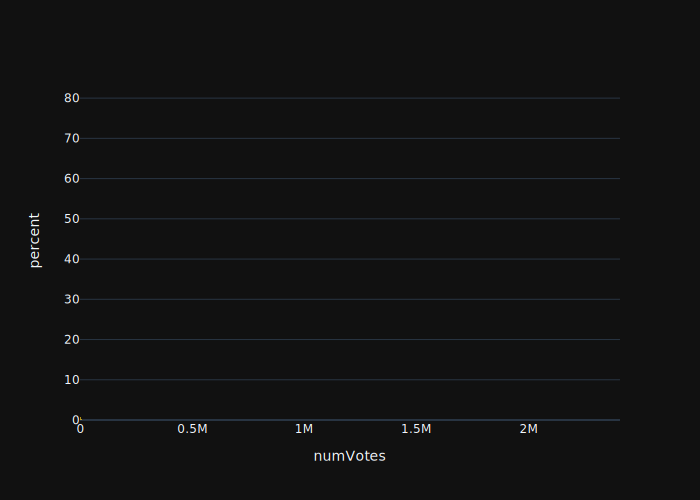

In [6]:
# EXTREMELY skewed
# You can see a little bit better with the interactive plot
fig = px.histogram(df, x="numVotes", opacity=0.7, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

#### Awards

In [5]:
sks.tab(df, "awards_won", 2)

,N,%
No awards won,357317,83.62
Awards won,70018,16.38


---
### Quantitative variables
---
On average (and keeping in mind that I have deleted a few outliers), a movie lasts around 90mn. It's interesting to see the mean is quite close to the median. The distribution is right-skewed, there's a fair bit of very long movies.

Series are (obviously) shorter (a typical episode lasts 45mn on average, though it usually depends on the genre of the series). Long-lasting series seem quite rare: 75% of series have two seasons or less.

In [30]:
display(df.loc[df["titleType"]=="movie",["runtimeMinutes"]].describe())
display(df.loc[df["titleType"]=="tvSeries",["runtimeMinutes", "maxSeason"]].describe())

,runtimeMinutes
count,231601.000000
mean,93.511664
std,23.234740
min,2.000000
25%,81.000000
50%,91.000000
75%,103.000000
max,300.000000


,runtimeMinutes,maxSeason
count,39900.000000,59725.000000
mean,44.455188,2.529209
std,33.185980,3.767266
min,1.000000,1.000000
25%,26.000000,1.000000
50%,30.000000,1.000000
75%,60.000000,2.000000
max,300.000000,50.000000


It seems data quality is a bit of an issue. Athidhi (below) is [apparently only 179mn long](https://en.wikipedia.org/wiki/Athidhi_(2007_film)), not 300. I have neither the time nor the patience to cross-check the length of each film, so we will assume the IMDb database is correct.

In [49]:
# A few movies that are 300mn long
df.loc[(df["titleType"] == "movie") & (df["runtimeMinutes"] == 300)].sort_values(
    "numVotes", ascending=False
).loc[
    :,
    [
        "primaryTitle",
        "startYear",
        "genres",
        "runtimeMinutes",
        "numVotes",
        "averageRating",
    ],
].head()

,primaryTitle,startYear,genres,runtimeMinutes,numVotes,averageRating
220442,Athidhi,2007.0,Action,300.0,1809.0,5.6
502,Judex,1916.0,"Adventure,Crime",300.0,893.0,7.4
362237,September 11: The New Pearl Harbor,2013.0,Documentary,300.0,374.0,9.0
12281,The Spider Returns,1941.0,"Action,Adventure,Crime",300.0,236.0,6.9
9937,The Secret of Treasure Island,1938.0,"Action,Adventure,Crime",300.0,182.0,4.6


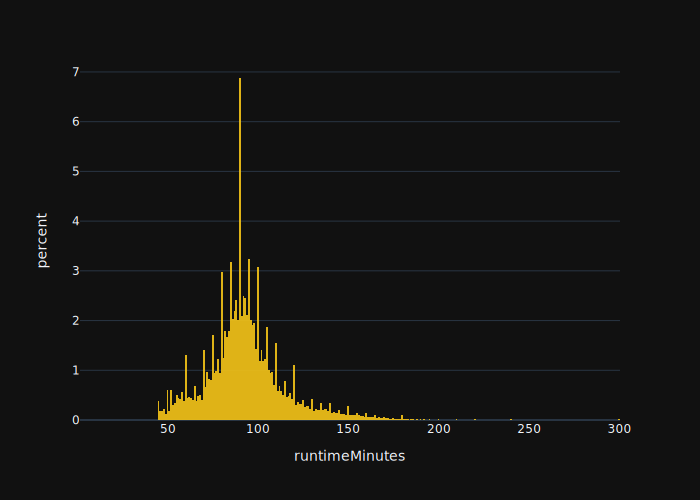

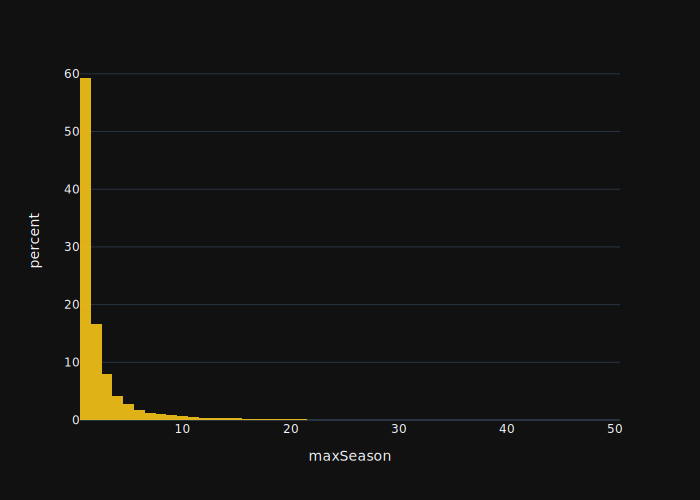

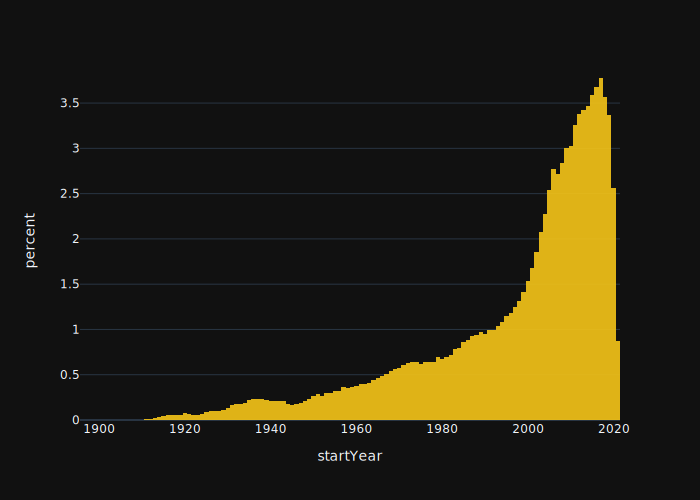

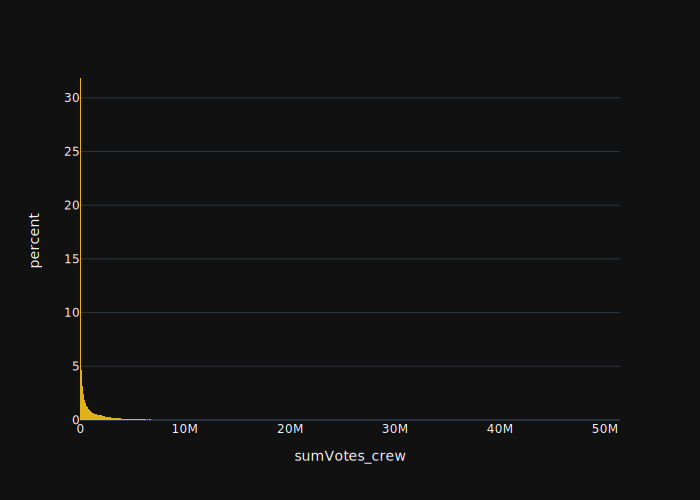

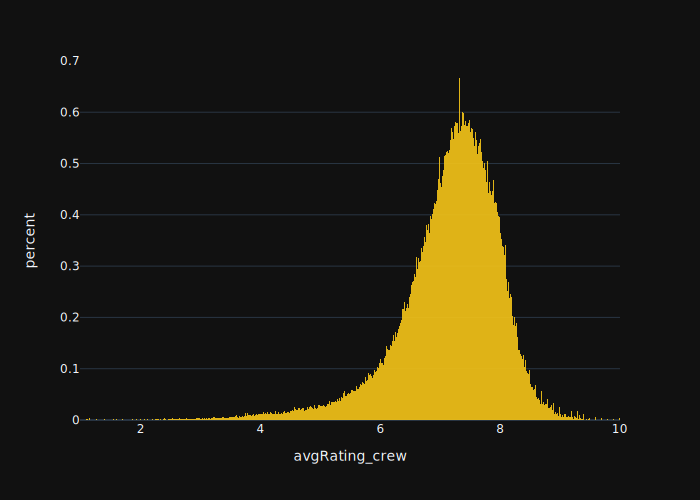

In [340]:
fig = px.histogram(df.loc[df["titleType"]=="movie"], x="runtimeMinutes", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# fig = px.histogram(df, x="runtimeMinutes", y="numVotes", histfunc='sum', opacity=0.9, histnorm='percent')
# fig.show()

fig = px.histogram(df.loc[df["titleType"]=="tvSeries"], x="maxSeason", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

fig = px.histogram(df, x="startYear", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

fig = px.histogram(df, x="sumVotes_crew", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

fig = px.histogram(df, x="avgRating_crew", opacity=0.9, histnorm='percent', color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

---
### Categorical variables
---
* `isAdult`: quite rare, all things considered. Either there's not that much porn movies, or nobody on IMDb bothers rating their porn after watching it.
* `genres`: Too many categories.
* `crew_size_indice`: utilité incertaine. On verra en bivarié.

In [52]:
for var in ["isAdult", "genres", "changed_title", "crew_size_indice"]:
    print(var)
    ICD.display(sks.tab(df, var, 2))

isAdult


,N,%
0.0,408984,95.71
1.0,18351,4.29


genres


,N,%
Drama,62378,14.60
Documentary,43815,10.25
Comedy,42059,9.84
Adult,13238,3.10
"Comedy,Drama",11009,2.58
...,...,...
"Action,History,Reality-TV",1,0.00
"Adventure,Horror,War",1,0.00
"Family,Game-Show,Sport",1,0.00
"Mystery,Sci-Fi,Talk-Show",1,0.00


changed_title


,N,%
0,362306,84.78
1,65029,15.22


crew_size_indice


,N,%
10.0,280108,65.55
9.0,37231,8.71
8.0,24481,5.73
7.0,17734,4.15
6.0,14816,3.47
5.0,13277,3.11
4.0,11850,2.77
3.0,10361,2.42
2.0,8782,2.06
1.0,8695,2.03


---
### Text vars
---

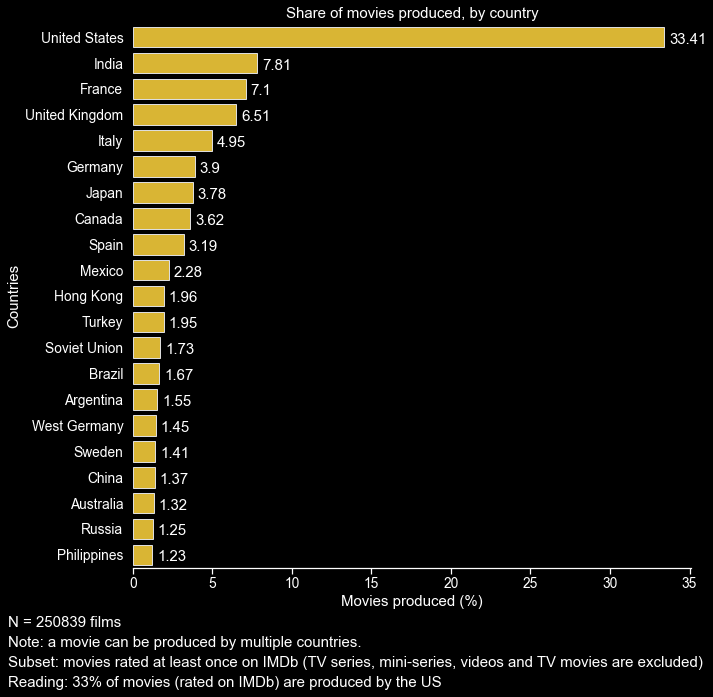

In [149]:
CVectorizer = CountVectorizer(tokenizer=lambda text: text.split(","))
fig = plt.figure(figsize=(10, 10))

# Create graph
ax = (
    pd.DataFrame(
        CVectorizer.fit_transform(
            df.loc[df["titleType"]=="movie", "country"].dropna("").str.replace(" ,|, ", ",", regex=True)
        ).todense(),
        columns=CVectorizer.get_feature_names(),
    )
    .assign(
        **{
            "united states": lambda x: x["usa"] + x["united states"],
            "united kingdom": lambda x: x["uk"] + x["united kingdom"],
        }
    )
    .drop(columns=["usa", "uk"])
    .sum()
    .sort_values(ascending=False)
    .rename("values")
    .reset_index()
    .assign(index=lambda x: x["index"].str.title(), values=lambda x: round(x["values"]/len(df.loc[df["titleType"]=="movie", "country"].dropna(""))*100, 2))
    .iloc[:21]
    .pipe((sns.barplot, "data"), y="index", x="values", color="#f5c518", edgecolor=("#dddddd"))
)

ax.set(title='Share of movies produced, by country', xlabel='Movies produced (%)', ylabel='Countries')

# Bar percentages
# https://datascience.stackexchange.com/questions/48035/how-to-show-percentage-text-next-to-the-horizontal-bars-in-matplotlib
for p in ax.patches:
        percentage = p.get_width()
        x = p.get_x() + p.get_width() + 0.3
        y = p.get_y() + p.get_height() - 0.15 #OP's selected answer divides by 2, but since I add annotations at the bottom of the graph the percentages are misaligned
        ax.annotate(percentage, (x, y))

# Footer
plt.annotate("N = "+str(len(df.loc[df["titleType"]=="movie", "country"].dropna("")))+" films", (0,0), (-125, -48), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Note: a movie can be produced by multiple countries. ", (0,0), (-125, -68), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Subset: movies rated at least once on IMDb (TV series, mini-series, videos and TV movies are excluded)", (0,0), (-125, -88), xycoords='axes fraction', textcoords='offset points', va='top')
plt.annotate("Reading: 33% of movies (rated on IMDb) are produced by the US", (0,0), (-125, -108), xycoords='axes fraction', textcoords='offset points', va='top')
# Keep bottom line
sns.despine(left=True)

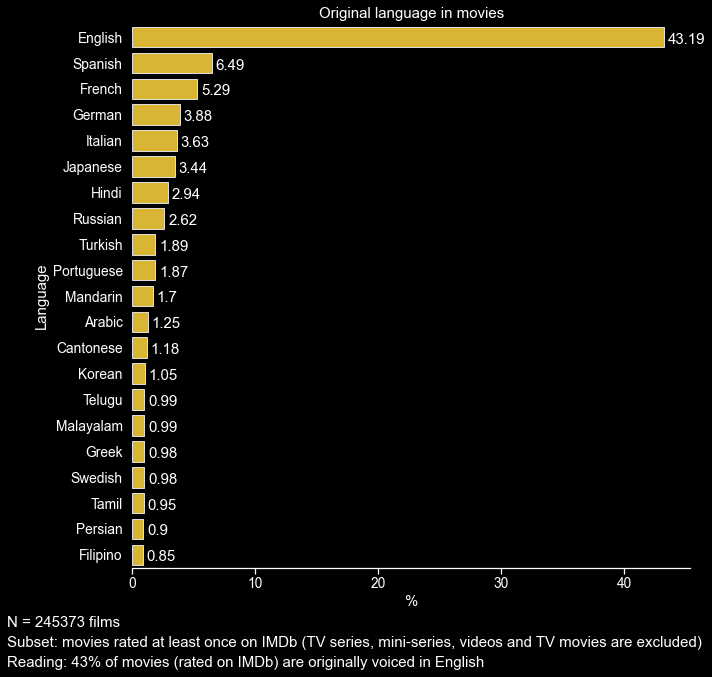

In [150]:
fig = plt.figure(figsize=(10, 10))
ax = (
    df.assign(
        language=df.loc[df["titleType"] == "movie", "language"]
        .dropna()
        .str.split(",")
        .str[0]
    )
    .value_counts("language", normalize=True)
    .reset_index()
    .rename(columns={0: "value"})
    .iloc[:21]
    .assign(value=lambda x: round(x["value"] * 100, 2))
    .pipe(
        (sns.barplot, "data"),
        x="value",
        y="language",
        color="#f5c518",
        edgecolor=("#dddddd"),
    )
)

# Axes titles
ax.set(title="Original language in movies", xlabel="%", ylabel="Language")

for p in ax.patches:
    percentage = p.get_width()
    x = p.get_x() + p.get_width() + 0.3
    y = (
        p.get_y() + p.get_height() - 0.15
    )  # OP's selected answer divides by 2, but since I add annotations at the bottom of the graph the percentages are misaligned
    ax.annotate(percentage, (x, y))
# Footer
plt.annotate(
    "N = "
    + str(len(df.loc[df["titleType"] == "movie", "language"].dropna()))
    + " films",
    (0, 0),
    (-125, -48),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "Subset: movies rated at least once on IMDb (TV series, mini-series, videos and TV movies are excluded)",
    (0, 0),
    (-125, -68),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "Reading: 43% of movies (rated on IMDb) are originally voiced in English",
    (0, 0),
    (-125, -88),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
# Keep bottom line only
sns.despine(left=True)

Funny thing: actors who have played in the most productions (not only movies, but also tv series, videos...) are mainly pornographic actors.

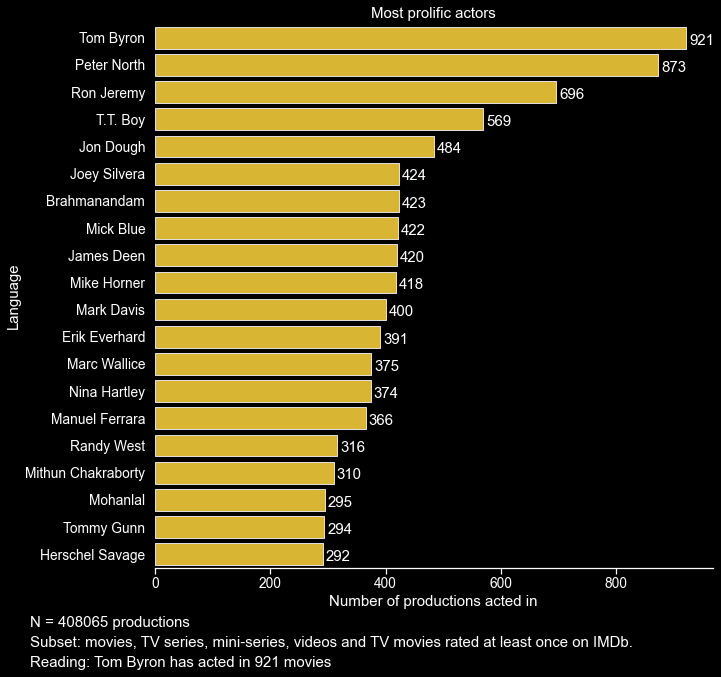

In [151]:
CVectorizer = CountVectorizer(max_features=20, tokenizer=lambda text: text.split(","))
fig = plt.figure(figsize=(10, 10))

# All movies
ax = (
    pd.DataFrame(
        CVectorizer.fit_transform(
            df["names_Actors"].dropna("").str.replace(" ,|, ", ",", regex=True)
        ).todense(),
        columns=CVectorizer.get_feature_names(),
    )
    .sum()
    .sort_values(ascending=False)
    .rename("values")
    .reset_index()
    .assign(index=lambda x: x["index"].str.title())
    .pipe(
        (sns.barplot, "data"),
        x="values",
        y="index",
        color="#f5c518",
        edgecolor=("#dddddd"),
    )
)
for p in ax.patches:
    count = p.get_width()
    x = p.get_x() + p.get_width() + 5
    y = (
        p.get_y() + p.get_height() - 0.15
    )  # OP's selected answer divides by 2, but since I add annotations at the bottom of the graph the percentages are misaligned
    ax.annotate(int(count), (x, y))
ax.set(
    title="Most prolific actors",
    xlabel="Number of productions acted in",
    ylabel="Language",
)

# Footer
plt.annotate(
    "N = " + str(len(df["names_Actors"].dropna(""))) + " productions",
    (0, 0),
    (-125, -48),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "Subset: movies, TV series, mini-series, videos and TV movies rated at least once on IMDb.",
    (0, 0),
    (-125, -68),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "Reading: Tom Byron has acted in 921 movies",
    (0, 0),
    (-125, -88),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)

sns.despine(left=True)

We get well-known names if we keep only mainstream movies. That's comforting.

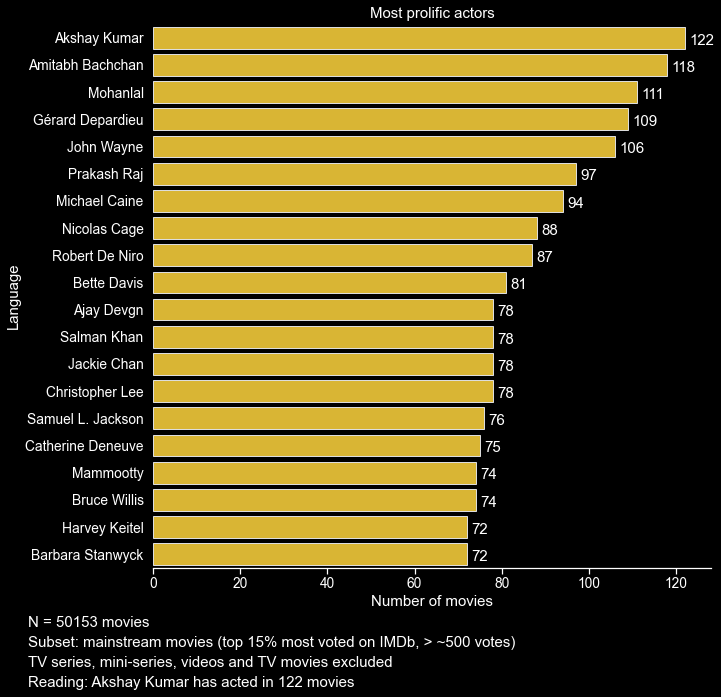

In [152]:
CVectorizer = CountVectorizer(max_features=20, tokenizer=lambda text: text.split(","))
fig = plt.figure(figsize=(10, 10))

# All movies
ax = (
    pd.DataFrame(
        CVectorizer.fit_transform(
            df.loc[(df["titleType"]=="movie") & (df["mainstream"]=="1"), "names_Actors"].dropna("").str.replace(" ,|, ", ",", regex=True)
        ).todense(),
        columns=CVectorizer.get_feature_names(),
    )
    .sum()
    .sort_values(ascending=False)
    .rename("values")
    .reset_index()
    .assign(index=lambda x: x["index"].str.title())
    .pipe(
        (sns.barplot, "data"),
        x="values",
        y="index",
        color="#f5c518",
        edgecolor=("#dddddd"),
    )
)
for p in ax.patches:
    count = p.get_width()
    x = p.get_x() + p.get_width() + 1
    y = (
        p.get_y() + p.get_height() - 0.15
    )  # OP's selected answer divides by 2, but since I add annotations at the bottom of the graph the percentages are misaligned
    ax.annotate(int(count), (x, y))
ax.set(title="Most prolific actors", xlabel="Number of movies", ylabel="Language")

# Footer
plt.annotate(
    "N = " + str(len(df.loc[(df["titleType"]=="movie") & (df["mainstream"]=="1"), "names_Actors"].dropna(""))) + " movies",
    (0, 0),
    (-125, -48),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "Subset: mainstream movies (top 15% most voted on IMDb, > ~500 votes)",
    (0, 0),
    (-125, -68),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "TV series, mini-series, videos and TV movies excluded",
    (0, 0),
    (-125, -88),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)
plt.annotate(
    "Reading: Akshay Kumar has acted in 122 movies",
    (0, 0),
    (-125, -108),
    xycoords="axes fraction",
    textcoords="offset points",
    va="top",
)

sns.despine(left=True)

## Bivariate

### Quantitative

#### Year

In [8]:
## YEAR

# Get weighted mean rating by year
groupby=df.groupby("startYear").agg(        
    Mean=("averageRating", lambda x: DescrStatsW(x, weights=df.loc[x.index, "numVotes"]/np.mean(df["numVotes"])).mean),
    LowCI=("averageRating", lambda x: DescrStatsW(x, weights=df.loc[x.index, "numVotes"]/np.mean(df["numVotes"])).tconfint_mean()[0]),
    HighCI=("averageRating", lambda x: DescrStatsW(x, weights=df.loc[x.index, "numVotes"]/np.mean(df["numVotes"])).tconfint_mean()[1])
).reset_index()

# Fill NA years
groupby=groupby.fillna({"LowCI": groupby["Mean"], "HighCI": groupby["Mean"]}, axis=0)
# Year 1911 has weird values. Inputting the mean.
groupby.loc[groupby["startYear"]==1911, ["LowCI", "HighCI"]] = groupby.loc[groupby["startYear"]==1911, ["Mean"]].values
groupby.loc[groupby["startYear"]==1912, ["LowCI", "HighCI"]] = groupby.loc[groupby["startYear"]==1912, ["Mean"]].values

# Annotations, major movies
best_1921 = df.loc[(df["startYear"]==1921) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]
best_1972 = df.loc[(df["startYear"]==1972) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]
best_1994 = df.loc[(df["startYear"]==1994) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]
best_2019 = df.loc[(df["startYear"]==2019) & (df["numVotes"]>50000), ["primaryTitle", "averageRating", "numVotes"]].sort_values("averageRating", ascending=False).iloc[0]

# Init
fig = go.Figure()

# Mean line
fig.add_trace(go.Scatter(
    name="Mean Rating",
    x=groupby["startYear"],
    y=groupby["Mean"],
    line_color='rgba(245,197,24,1)',
    showlegend=False
))
#CI
fig.add_trace(go.Scatter(
    name="High CI",
    x=groupby["startYear"],
    y=groupby["HighCI"],
    mode="lines",
    line_color='rgba(255, 255, 255, 0)',
    showlegend=False
))
fig.add_trace(go.Scatter(
    name="Low CI",
    x=groupby["startYear"],
    y=groupby["LowCI"],
    mode="lines",
    fill='tonexty',
    fillcolor='rgba(245,197,24, 0.2)',
    line_color='rgba(255,255,255,0)',
    showlegend=False
))

fig.add_annotation(x=1912, y=7.5, xanchor="right", align="right",
            text="Not enough data before<br>this date to construct<br>confidence intervals",
            opacity=0.8,
            showarrow=False,
            arrowhead=1)
fig.add_vline(x=1912, y0=8.5, line_dash="dash", line_color="gray", line_width=0.5)

#Major films
fig.add_annotation(x=1921, y=groupby.loc[groupby["startYear"]==1921]["Mean"].values[0],
            text=f"{best_1921[0]} ({best_1921[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1972, y=groupby.loc[groupby["startYear"]==1972]["Mean"].values[0],
            text=f"{best_1972[0]} ({best_1972[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1994, y=groupby.loc[groupby["startYear"]==1994]["Mean"].values[0],
            text=f"{best_1994[0]} ({best_1994[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=2019, y=groupby.loc[groupby["startYear"]==2019]["Mean"].values[0],
            text=f"{best_2019[0]} ({best_2019[1]}/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)

fig.update_layout(hovermode="x")
fig.show()

C:\Users\Didi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\weightstats.py:228: RuntimeWarning:

invalid value encountered in sqrt



In [ ]:
## Régression Year
## ! Use ranges instead

regression = sms.ols(formula='averageRating ~ C(startYear, Treatment(1980))', data=df).fit(cov_type="HC1")
regression.summary()

In [69]:
fig = df.groupby("startYear")["awards_won"].value_counts().unstack(
    fill_value=0
).unstack().reset_index().loc[lambda x: x["awards_won"] == "Awards won"].rename(
    columns={0: "Count"}
).pipe(
    (px.line, "data_frame"), x="startYear", y="Count", color_discrete_sequence=['rgba(245,197,24,1)'], title="Number of awards won per year", labels={"startYear": "Year", "Count":"Awards"}
)
#fig.update_layout(font_family="Roboto")
fig.show()
# ax.set(title="Original language in movies", xlabel="%", ylabel="Language")

In [11]:
## Most common genre per year
## Usually dramas

most_common_genre = pd.merge(
    df.groupby(["startYear", "main_genre"]).agg(Count=("main_genre", "count")).reset_index(),
    df.groupby(["startYear", "main_genre"]).agg(Count=("main_genre", "count")).reset_index().groupby("startYear")["Count"].max().reset_index(),
    on=["startYear", "Count"],
    how="right")
films_year = df.groupby("startYear").agg(Count=("tconst", "count"))

groupby = pd.merge(most_common_genre, films_year, on="startYear", how="left")

fig = go.Figure()

# Mean line
fig.add_trace(go.Scatter(
    name="Mean Rating",
    x=groupby["startYear"],
    y=groupby["Count_y"],
    line_color='rgba(245,197,24,1)',
    showlegend=False,
    hovertext="Most common genre this year: " + groupby["main_genre"] + " (" + groupby["Count_x"].astype("str") + ")"
))
fig.show()

#### Average ratings, numVotes, crew...

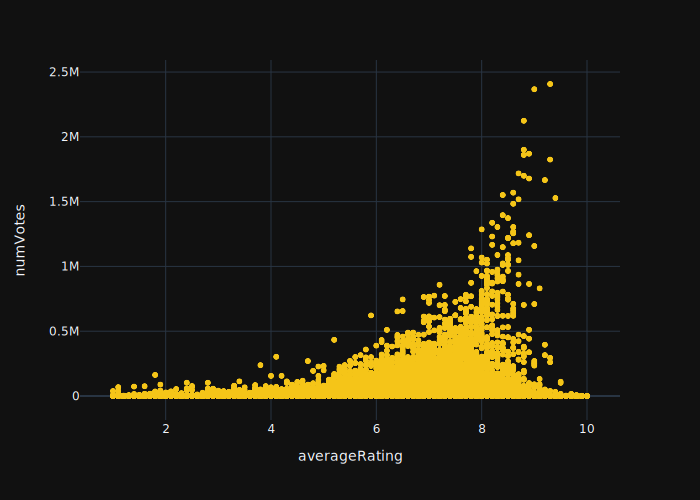

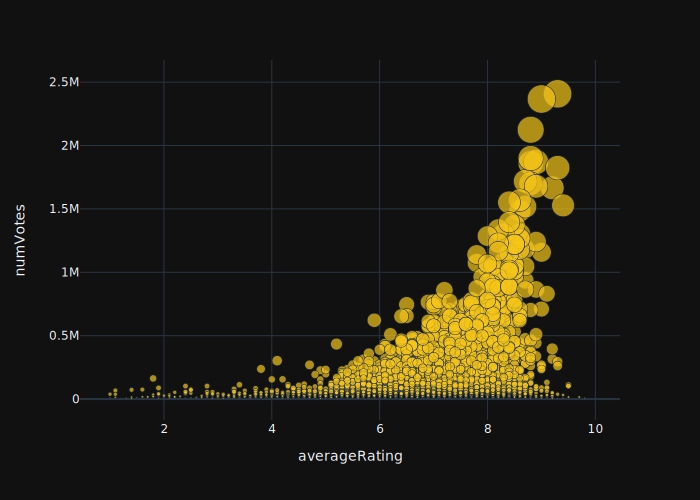

In [26]:
# Link for formatting
# https://plotly.com/python/hover-text-and-formatting/

# Ratings * nb of votes (unweighted)
fig = px.scatter(df, x="averageRating", y="numVotes", hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Ratings * nb of votes (weighted)
# Use the notebook rendered to see the name of the films!
fig = px.scatter(df.loc[df["mainstream"]=="1"], x="averageRating", y="numVotes", size='numVotes', hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

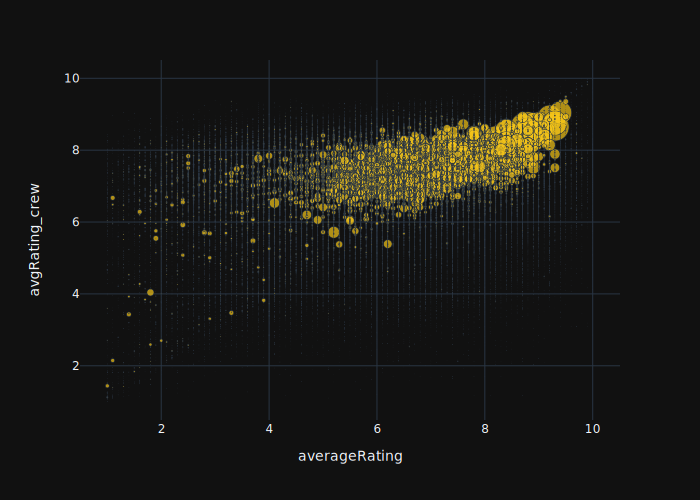

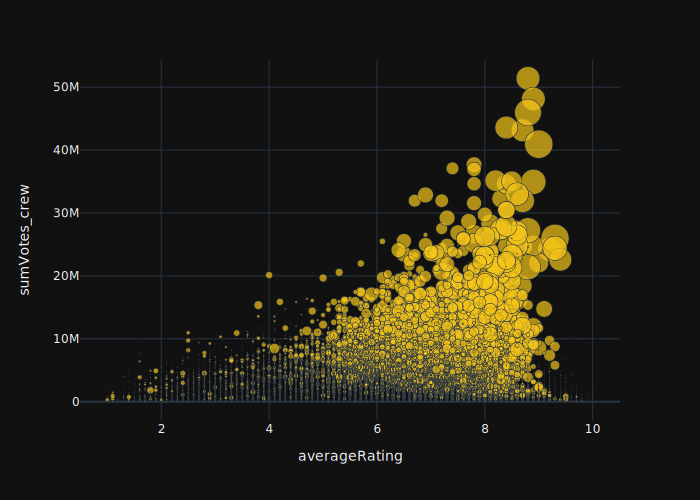

In [6]:
# Film ratings * crew rating
# Well, it's kind of colinear, since the rating of the film is also used to calculate the crew rating
fig = px.scatter(df, x="averageRating", y="avgRating_crew", size='numVotes', hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

# Film ratings * crew number of votes
fig = px.scatter(df, x="averageRating", y="sumVotes_crew", size='numVotes', hover_name="primaryTitle", color_discrete_sequence=["rgb(245,197,24)"])
fig.show(renderer=plotly_renderer)

#### Movie length

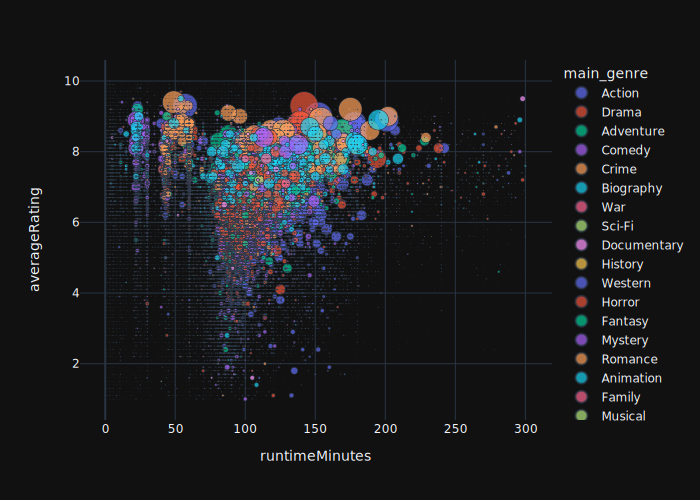

In [7]:
# It's a bit crowded, but with the notebook renderer you can choose which genres to see

fig = px.scatter(df, x="runtimeMinutes", y="averageRating", size='numVotes', color="main_genre", hover_name="primaryTitle")
fig.show(renderer=plotly_renderer)

In [75]:
print("Average runtime X awards won (movies, TV series, mini series, TV movies, videos)")
display(sks.gr_meanci(df, "awards_won", "runtimeMinutes"))

print("Average runtime X awards won (subset: movies only)")
display(sks.gr_meanci(df.loc[df["titleType"]=="movie"], "awards_won", "runtimeMinutes"))

Average runtime X awards won (movies, TV series, mini series, TV movies, videos)


,N,Mean,low_CI,high_CI
awards_won,,,,
Awards won,65412,94.306075,94.064947,94.547203
No awards won,289339,81.404007,81.273486,81.534528


Average runtime X awards won (subset: movies only)


,N,Mean,low_CI,high_CI
awards_won,,,,
Awards won,53204,99.669611,99.479721,99.859502
No awards won,178397,91.675157,91.567599,91.782715


In [ ]:
# Visiblement on va garder numVotes dans le vecteur poids
regression = sms.glm("averageRating ~ runtimeMinutes + numVotes", df).fit(cov_type="HC1")
regression.summary()

### Categorical

In [76]:
print("Weighted average rating per genre")
sks.weighted_gr_meanci(df, "main_genre", "averageRating", "numVotes").sort_values("Mean", ascending=False)

Weighted average rating per genre


,N,Mean,LowCI,HighCI
main_genre,,,,
Western,2484,7.871624,7.794763,7.948486
Film-Noir,30,7.722951,7.653203,7.792699
Crime,19535,7.650581,7.640487,7.660675
Mystery,2146,7.609239,7.574859,7.643619
Biography,10940,7.570222,7.560573,7.579871
Animation,10653,7.466406,7.440784,7.492028
Drama,99242,7.364728,7.357609,7.371846
Documentary,61119,7.361752,7.326480,7.397024
Adventure,16187,7.250578,7.241064,7.260093


'Unweighted'

,N,Mean,low_CI,high_CI
mainstream,,,,
0,360345,6.371940,6.367232,6.376647
1,66990,6.347658,6.337955,6.357361


'Weighted'

,N,Mean,LowCI,HighCI
mainstream,,,,
0,360345,6.112449,6.085434,6.139464
1,66990,7.146154,7.142911,7.149397


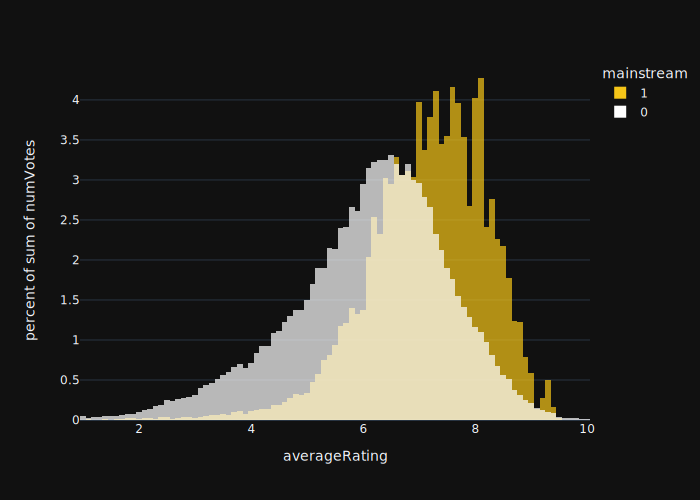

In [77]:
display("Unweighted", sks.gr_meanci(df, "mainstream", "averageRating"))
display("Weighted", sks.weighted_gr_meanci(df, "mainstream", "averageRating", "numVotes"))
# fig = px.histogram(df, x="averageRating", color="mainstream", opacity=0.7, histnorm='percent', barmode='overlay')
# fig.show()

fig = px.histogram(df, x="averageRating", y="numVotes", color="mainstream", histfunc='sum', opacity=0.7, histnorm='percent', barmode='overlay', color_discrete_sequence=["rgb(245,197,24)", "rgb(255,255,255)"])
fig.show(renderer=plotly_renderer)

#### Adult films

'Unweighted'

,N,Mean,low_CI,high_CI
isAdult,,,,
0.0,408984,6.368233,6.363870,6.372595
1.0,18351,6.365915,6.347299,6.384531


'Weighted'

,N,Mean,LowCI,HighCI
isAdult,,,,
0.0,408984,7.121847,7.118582,7.125112
1.0,18351,6.162524,5.978849,6.346198


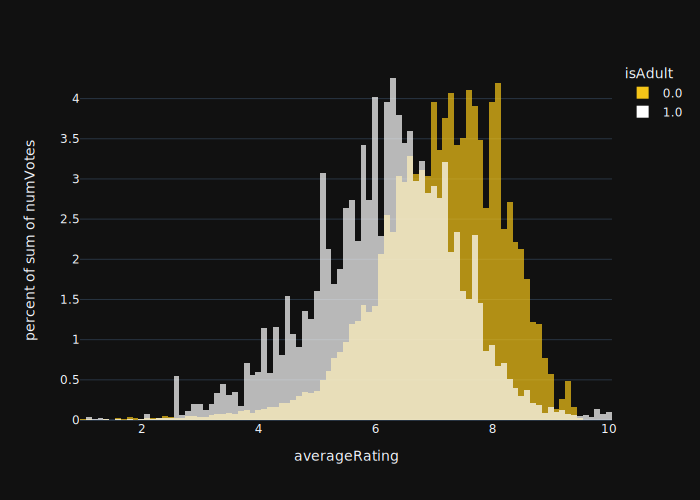

In [18]:
## À noter que "adult" est une catégorie dans "main_genre"

display("Unweighted", sks.gr_meanci(df, "isAdult", "averageRating"))
display("Weighted", sks.weighted_gr_meanci(df, "isAdult", "averageRating", "numVotes"))

# fig = px.histogram(df, x="averageRating", color="isAdult", opacity=0.7, histnorm='percent', barmode='overlay')
# fig.show()

fig = px.histogram(df, x="averageRating", y="numVotes", color="isAdult", histfunc='sum', opacity=0.7, histnorm='percent', barmode='overlay', color_discrete_sequence=["rgb(245,197,24)", "rgb(255,255,255)"])
fig.show(renderer=plotly_renderer)

#### Régression

In [5]:
regression = sms.ols("averageRating ~ runtimeMinutes + C(main_genre, Treatment('Action'))", df, var_weights=np.asarray(df['numVotes'])).fit(cov_type="HC1")
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          averageRating   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     1932.
Date:                Sat, 10 Jul 2021   Prob (F-statistic):               0.00
Time:                        20:18:03   Log-Likelihood:            -5.9408e+05
No. Observations:              354751   AIC:                         1.188e+06
Df Residuals:                  354722   BIC:                         1.189e+06
Df Model:                          28                                         
Covariance Type:                  HC1                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             5.9533      0.010    572.238      0.000       5.933       5.974
C(main_genre, Treatment('Action'))[T.Adult]           0.4986      0.014     36.928      0.000       0.472       0.525
C(main_genre, Treatment('Action'))[T.Adventure]       0.3707      0.014     27.167      0.000       0.344       0.397
C(main_genre, Treatment('Action'))[T.Animation]       0.6400      0.016     39.081      0.000       0.608       0.672
C(main_genre, Treatment('Action'))[T.Biography]       1.1553      0.013     87.961      0.000       1.130       1.181
C(main_genre, Treatment('Action'))[T.Comedy]          0.2877      0.009     31.317      0.000       0.270       0.306
C(main_genre, Treatment('Action'))[T.Crime]           0.4130      0.012     34.188      0.000       0.389       0.437
C(main_genre, Treatment('Action'))[T.Documentary]     1.2851      0.009    136.681      0.000       1.267       1.304
C(main_genre, Treatment('Action'))[T.Drama]           0.5371      0.009     61.145      0.000       0.520       0.554
C(main_genre, Treatment('Action'))[T.Family]          0.5837      0.023     25.593      0.000       0.539       0.628
C(main_genre, Treatment('Action'))[T.Fantasy]         0.2199      0.035      6.249      0.000       0.151       0.289
C(main_genre, Treatment('Action'))[T.Film-Noir]       0.7428      0.130      5.698      0.000       0.487       0.998
C(main_genre, Treatment('Action'))[T.Game-Show]      -0.0598      0.047     -1.273      0.203      -0.152       0.032
C(main_genre, Treatment('Action'))[T.History]         0.9767      0.049     19.823      0.000       0.880       1.073
C(main_genre, Treatment('Action'))[T.Horror]         -1.0414      0.015    -67.304      0.000      -1.072      -1.011
C(main_genre, Treatment('Action'))[T.Music]           1.5088      0.026     57.717      0.000       1.458       1.560
C(main_genre, Treatment('Action'))[T.Musical]         0.7202      0.041     17.718      0.000       0.641       0.800
C(main_genre, Treatment('Action'))[T.Mystery]         0.1763      0.032      5.573      0.000       0.114       0.238
C(main_genre, Treatment('Action'))[T.News]           -0.2247      0.068     -3.303      0.001      -0.358      -0.091
C(main_genre, Treatment('Action'))[T.Reality-TV]      0.1827      0.035      5.275      0.000       0.115       0.251
C(main_genre, Treatment('Action'))[T.Romance]         0.2262      0.024      9.276      0.000       0.178       0.274
C(main_genre, Treatment('Action'))[T.Sci-Fi]         -0.3736      0.043     -8.723      0.000      -0.458      -0.290
C(main_genre, Treatment('Action'))[T.Short]           0.8500      0.036     23.529      0.000       0.779       0.921
C(main_genre, T

In [ ]:
regression = sms.glm("averageRating ~ runtimeMinutes + C(main_genre, Treatment('Action'))", df, var_weights=np.asarray(df['numVotes'])).fit(cov_type="HC1")
regression.summary()

In [ ]:
from IPython.display import HTML
HTML(filename="./Regressions.html")

### Awards

In [80]:
df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'changed_title', 'main_genre',
       'averageRating', 'numVotes', 'n_titles', 'sumVotes_Actors',
       'sumVotes_Director', 'sumVotes_Others', 'avgRating_weighted_Actors',
       'avgRating_weighted_Director', 'avgRating_weighted_Others', 'maxSeason',
       'crew_size_indice', 'sumVotes_crew', 'avgRating_crew', 'mainstream',
       'log_numVotes', 'rated', 'awards', 'country', 'language', 'plot',
       'boxoffice', 'production', 'names_Actors', 'names_Director',
       'names_Others', 'Names', 'awards_nom_or_won', 'awards_won',
       'all_texts'],
      dtype='object')

Some interesting things: biographies are the most likely genre to have an award (3 in ten). Followed close by by dramas.

In [84]:
df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'changed_title', 'main_genre',
       'averageRating', 'numVotes', 'n_titles', 'sumVotes_Actors',
       'sumVotes_Director', 'sumVotes_Others', 'avgRating_weighted_Actors',
       'avgRating_weighted_Director', 'avgRating_weighted_Others', 'maxSeason',
       'crew_size_indice', 'sumVotes_crew', 'avgRating_crew', 'mainstream',
       'log_numVotes', 'rated', 'awards', 'country', 'language', 'plot',
       'boxoffice', 'production', 'names_Actors', 'names_Director',
       'names_Others', 'Names', 'awards_nom_or_won', 'awards_won',
       'all_texts'],
      dtype='object')

In [86]:
twoway(df, ["main_genre", "titleType", "mainstream"], ["awards_won"], axis_percent=1)

Col variable: awards_won
Row variable: main_genre


,N,Awards won,No awards won
Drama,99242,24.91,75.09
Comedy,91928,15.68,84.32
Documentary,61119,14.20,85.80
Action,38396,13.93,86.07
Crime,19535,18.91,81.09
Adult,17907,4.85,95.15
Adventure,16187,16.58,83.42
Horror,13351,10.78,89.22
Biography,10940,30.07,69.93
Animation,10653,9.30,90.70


Chi2: 12521.5199; P-value: 0.0

Row variable: titleType


,N,Awards won,No awards won
movie,254126,21.50,78.50
tvSeries,70353,12.57,87.43
video,46989,3.10,96.90
tvMovie,45624,8.38,91.62
tvMiniSeries,10243,12.25,87.75


Chi2: 13914.2483; P-value: 0.0

Row variable: mainstream


,N,Awards won,No awards won
0,360345,11.72,88.28
1,66990,41.47,58.53


Chi2: 36479.7661; P-value: 0.0



---
# NLP
---

## SETUP

Launch this before doing anything else here

In [6]:
# Good discussion about the performance of various ways to remove words/punctuation: https://stackoverflow.com/questions/50444346/fast-punctuation-removal-with-pandas

# WordNet:
# [WordNetLemmatizer.lemmatize(word, get_wordnet_pos(word, WordNetPOSDict)) for word in x.split()]
# Porter:
# [PorterStemmer.stem(word) for word in x.split()]

# If there is a csv file with the lemmatized descriptions, load it and merge it with df_desc
if os.path.exists(os.path.join("Data", "Final", "lemmatized_descriptions.csv")):
    df_desc = (
        df_desc.merge(
            pd.read_csv(
                os.path.join("Data", "Final", "lemmatized_descriptions.csv"),
                names=["tconst", "plot_lemmatized"],
            ),
            on="tconst",
            how="left",
        )
        .drop(columns=["plot"])
        .rename(columns={"plot_lemmatized": "plot"})
    )
# Else, lemmatize the descriptions (~4000 seconds)
else:
    df_desc = df_desc.assign(
        plot=df_desc["plot"]
        .str.lower()
        .str.replace(
            r"\b(?:{})\b".format("|".join(stop_words)), "", regex=True # Deleting stop words (! do it before deleting punctuation, there's punctuation in the stop words)
        )  
        .str.replace(r"[^\w\s]+", "", regex=True)  # Deleting punctuation
        # Lemmatization
        # WordNet needs a "part-of-speech tag" to properly lemmatize. It doesn't apply the same modification to a verb and to a noun. get_wordnet_pos() retrieves the correct part-of-speech tag for each word.
        # The lemmatizer is a bit slow (slower than PorterStemmer, at least), because the get_wordnet_pos function calls nltk.tag.pos_tag().
        # It takes between one to two hours
        .progress_apply(
            lambda x: " ".join(
                [
                    WordNetLemmatizer.lemmatize(
                        word, get_wordnet_pos(word, WordNetPOSDict)
                    )
                    for word in x.split()
                ]
            )
        )  
    )
    df_desc.loc[:, ["tconst", "plot"]].rename(
        columns={"plot": "plot_lemmatized"}
    ).to_csv(os.path.join("Data", "Final", "lemmatized_descriptions.csv"))

# It also seems there are a few NAs and empty plot descriptions after deleting the stop words.
df_desc = df_desc.assign(
    plot=df_desc["plot"]
    .str.replace(
        r"\b(?:{})\b".format(
            "|".join(["movie", "film", "story", "series", "documentary"])
        ),
        "",
        regex=True,
    )
    .replace("", np.NaN) # Some empty strings should be NaN instead
).dropna(subset=["plot"])

---
## Clustering on TF-IDF
---

I applied the typical preprocessing for text data: common stop words and punctuation were deleted, and words were lemmatized.
The lemmatizer is quite slow. I exported the lemmatized plot descriptions to a .csv. Use it if you want to avoid waiting an hour for the lemmatization to finish.

I eventually decided to remove a few very common words in movie plot descriptions: "movie", "film", "series", "documentary", "story". The first three are not about the plot of the film (or series), but about the film itself (though some movies are about producing a movie, like Sion Sono's Why Don't You Play in Hell?). "Story", well, movies tell stories.

I'm still conflicted about deleting "documentary": on one hand, it's just a genre (plus I could merge the genres variable with the plot description), on the other hand, documentaries are very different from other types of movies. 

The quality of the plot descriptions is inconsistent. Some are very short, and clearly unfinished. Others are very detailled. Half of them have around 20 "meaningful" (let's call them that, since stop words have been removed) words. 



Five random plots:
 [['Lung Neaw Visits His Neighbours'
  'follow lung neaw living land visit neighbour world simple reality existence marked compassion environment fellow villager']
 ["Trafic d'art: Le grand marchandage"
  'boost globalisation resale network internet lure gain art traffic third large illegal trade world activity everyone close eye']
 ['Webdreams'
  'webdreams welcome world internet porn underground industry montreal boom business webcam girl wannabe seek celebrity entrepreneur struck rich hop']
 ['Silentium'
  'man accuse catholic bishop abuse child dy austrian city salzburg everyone except widow eccentrical detective simon brenner keep silent believe man kill']
 ['Sen Kiminle Dans Ediyorsun'
  'selim young doctor search 100th patient finish thesis come across beautiful young girl aysel try commit suicide possible cure dance become']] 

Number of words in each plot description, descriptive statistics:
 count    304416.000000
mean         32.331717
std          31.6535

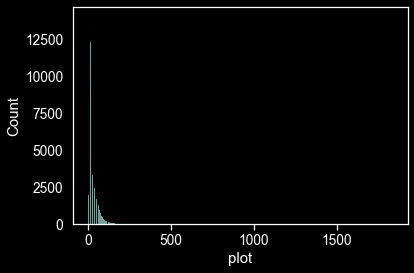

In [5]:
print(
    "Five random plots:\n",
    df_desc.loc[:,["primaryTitle", "plot"]].sample(5, random_state=451).values, "\n"
)
print(
    "Number of words in each plot description, descriptive statistics:\n",
    df_desc["plot"].str.split().apply(len).describe()
)
# Histogram of the number of words in descriptions
sns.histplot(df_desc["plot"].str.split().apply(len));

The 30 most common words in movie plots. You can probably make the most clichéd movie plot with this.

In [11]:
TFIDF = TfidfVectorizer(max_features=30)
tfidf_matrix = TFIDF.fit_transform(df_desc.loc[:,"plot"])

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=TFIDF.get_feature_names()
).sum().sort_values(ascending=False)

life      28473.364214
one       20264.262521
young     18577.384943
find      17929.367746
take      17716.518054
get       17712.512824
love      17326.763072
world     16380.365616
new       15829.970458
family    15714.933882
two       15705.473348
woman     15382.101571
make      15167.571144
man       15050.151704
friend    14954.791780
year      14868.171519
go        14730.443504
time      12189.179408
work      12169.445138
girl      11742.825251
try       11408.966910
show      11217.614731
come      11126.133962
people    10673.788790
day       10511.940314
father    10439.270312
help       9643.289098
old        9482.311986
way        8890.692247
meet       8692.815715
dtype: float64

### KMeans on raw TF-IDF, and testing the optimal number of clusters (the bad way)

My initial idea was just to do KMeans on the TF-IDF embedding. What could go wrong?

In [64]:
# https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html
# https://stats.stackexchange.com/questions/199501/user-segmentation-by-clustering-with-sparse-data
# Apparently, I should reduce the dimensionality of the dataset using truncated SVD. It apparently works well with sparse matrices.
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html 

TFIDF = TfidfVectorizer(max_features=2000)
# I took a random sample of 4000 observations only, just so it goes faster.
# It still takes ~400s
tfidf_matrix = TFIDF.fit_transform(df_desc.sample(4000, random_state=451).loc[:,"plot"])

inertias = {}
silhouette = {}
for k in range(2,30):
    km = KMeans(n_clusters=k)
    km.fit(tfidf_matrix)
    inertias[k]=km.inertia_
    silhouette[k] = metrics.silhouette_score(tfidf_matrix, km.labels_, metric='euclidean')

Everything goes wrong, actually. I am not sure if KMeans is very useful with that much text data. There is a tutorial on scikit-learn.org about [clustering text documents with k-means](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html); it seems the Silhouette score is very low due to the large number of variables/words typically used in NLP. I also can't find an elbow in the inertia plot. 

Someone on CrossValidated advises to [reduce dimensionality beforehand](https://stats.stackexchange.com/questions/199501/user-segmentation-by-clustering-with-sparse-data), which is what I will do.

Nevertheless, for curiosity's sake, I'll do a quick analysis on a clustering with k = 10.

Silhouette scores: {2: 0.0028888844049723803, 3: 0.001873649235565653, 4: 0.0025645609501847837, 5: 0.003168155524152665, 6: 0.0031878037204296616, 7: 0.003871957016875356, 8: 0.0045159702650471555, 9: 0.004541915104216616, 10: 0.005092829225837187, 11: 0.0056791788773206415, 12: 0.0053772210456141615, 13: 0.005823827547749439, 14: 0.006431615293881222, 15: 0.006765015781406964, 16: 0.007268740466403165, 17: 0.007392024353324397, 18: 0.007197835144565665, 19: 0.0071486536404023185, 20: 0.007644094455008066, 21: 0.008551523526313436, 22: 0.008040774070784018, 23: 0.00816866925894071, 24: 0.00848053813845375, 25: 0.008629488182436668, 26: 0.009045313944144593, 27: 0.009055697871410896, 28: 0.009266280831876035, 29: 0.00884745830424616}


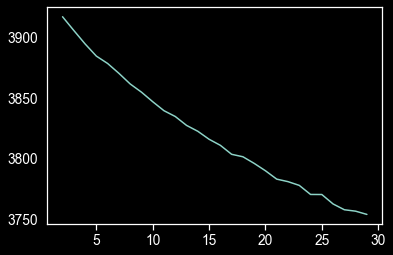

In [70]:
# This is abysmal
# Where is the elbow?
plt.plot(list(inertias.keys()), list(inertias.values()))
print("Silhouette scores:", silhouette)

I decided (arbitrarily) to create 10 clusters. It's easy enough to analyse.

In [12]:
TFIDF = TfidfVectorizer(max_features=4000)
tfidf_matrix = TFIDF.fit_transform(df_desc.loc[:,"plot"])

km = KMeans(n_clusters=10)
km.fit(tfidf_matrix)

# Clusters to df
df_desc = df_desc.assign(
    kmeans10=km.labels_
)
# Oneway table of the clusters
sks.tab(df=df_desc, var="kmeans10", round_int=2)

,N,%
0,113072,37.14
3,68705,22.57
4,26529,8.71
2,18652,6.13
1,17046,5.60
5,16904,5.55
7,16778,5.51
6,10293,3.38
8,8272,2.72
9,8165,2.68


I'm actually quite satisfied with some of those clusters. 
* Cluster 0 definitely deals about World War I&II. 
* Cluster 1... some slice of life movies ? I don't know. These words seem generic.
* Cluster 2 seems a bit more dramatic, and deals about family
* Cluster 3 is also about family, but there is love in it. 
* Cluster 4 deals about friendship, schools. Teen movies ?
* Cluster 5 is super clear: murder movies! cops! serial killers!
* Cluster 6 are those tv games, and probably reality shows.
* Cluster 7: another one about family ?

In [13]:
top_words = pd.DataFrame(
    tfidf_matrix.todense(),
    columns=TFIDF.get_feature_names()
).assign(kmeans10=km.labels_).groupby("kmeans10").sum().transpose()

for col in top_words.columns:
    print("Most common words, cluster:", col)
    print(top_words[col].sort_values(ascending = False).iloc[:20].index.tolist())
    print("\n")

twoway(data=df_desc, rowvars=["main_genre", "mainstream"], colvars=["kmeans10"], axis_percent=0)

Most common words, cluster: 0
['new', 'make', 'people', 'group', 'one', 'take', 'follow', 'two', 'year', 'music', 'feature', 'set', 'time', 'team', 'work', 'star', 'first', 'video', 'war', 'american']


Most common words, cluster: 1
['love', 'fall', 'girl', 'young', 'life', 'man', 'meet', 'find', 'two', 'one', 'get', 'friend', 'daughter', 'father', 'woman', 'marry', 'make', 'relationship', 'go', 'married']


Most common words, cluster: 2
['world', 'war', 'one', 'life', 'ii', 'around', 'new', 'take', 'year', 'people', 'find', 'two', 'make', 'time', 'young', 'first', 'follow', 'journey', 'man', 'human']


Most common words, cluster: 3
['get', 'find', 'friend', 'man', 'one', 'young', 'go', 'father', 'take', 'girl', 'two', 'try', 'wife', 'kill', 'year', 'mother', 'old', 'help', 'son', 'daughter']


Most common words, cluster: 4
['life', 'change', 'one', 'young', 'new', 'year', 'friend', 'man', 'people', 'day', 'work', 'make', 'take', 'find', 'follow', 'two', 'time', 'come', 'get', 'live']


,N,0,1,2,3,4,5,6,7,8,9
Drama,72507,16.60,41.03,17.41,26.87,31.99,35.20,8.57,35.89,29.87,14.93
Comedy,66080,18.61,29.04,12.29,25.15,22.01,21.85,31.57,23.53,29.06,16.93
Documentary,41963,20.50,2.97,27.09,2.12,14.20,7.48,14.95,9.19,7.22,37.43
Action,32143,11.79,6.44,13.44,14.08,6.63,6.37,3.80,7.14,7.95,5.55
Crime,15773,4.74,2.83,2.58,8.19,4.07,7.01,2.18,4.60,2.83,4.03
Adventure,12820,4.64,3.06,6.67,4.87,2.98,2.31,2.56,3.33,3.19,2.39
Horror,11544,3.55,1.06,2.40,5.78,2.29,5.50,1.96,3.90,4.36,2.12
Biography,9128,3.51,1.68,4.82,1.10,6.59,2.03,1.92,2.68,1.61,4.27
Animation,7639,3.11,1.43,3.65,1.85,1.94,0.57,3.24,1.76,6.59,1.63
Thriller,4406,1.15,0.82,0.88,2.22,1.62,2.56,0.48,1.29,0.96,0.87


Chi2: 68986.0428; P-value: 0.0

Row variable: mainstream


,N,0,1,2,3,4,5,6,7,8,9
0,237805,82.54,76.99,77.28,70.56,78.49,80.17,85.07,74.69,71.7,84.18
1,66611,17.46,23.01,22.72,29.44,21.51,19.83,14.93,25.31,28.3,15.82


Chi2: 4432.101; P-value: 0.0



The second group has the highest average number of votes (not surprising, as I explained earlier it has the most mainstream movies). However the "best" films are in the last group. If I recall correctly, documentaries are usually well rated.

In [14]:
print("Average number of votes")
display(sks.gr_meanci(df_desc, "kmeans10", "numVotes"))
print("Weighted average rating")
display(sks.weighted_gr_meanci(df_desc, "kmeans10", "averageRating", "numVotes"))

Average number of votes


,N,Mean,low_CI,high_CI
kmeans10,,,,
3,68705,5202.926323,4913.955168,5491.897477
2,18652,5136.758793,4519.776520,5753.741065
8,8272,3784.011485,3225.536006,4342.486963
7,16778,3299.305638,2813.149107,3785.462169
4,26529,3282.329112,2857.580541,3707.077682
0,113072,2460.377467,2298.751201,2622.003734
1,17046,2187.230611,1876.888786,2497.572437
5,16904,1846.702319,1589.139964,2104.264674
9,8165,1705.912554,1314.799507,2097.025600


Weighted average rating


,N,Mean,LowCI,HighCI
kmeans10,,,,
0,113072,7.163984,7.156497,7.171471
1,17046,7.051871,7.032711,7.071031
2,18652,7.138986,7.127504,7.150469
3,68705,7.059416,7.052995,7.065838
4,26529,7.343251,7.330670,7.355832
5,16904,6.857628,6.836344,6.878913
6,10293,7.290838,7.254279,7.327396
7,16778,7.270764,7.253500,7.288029
8,8272,6.915237,6.894948,6.935526


Let's try reducing the dimensions of the TF-IDF embeddings instead of clustering.

---
### TF-IDF and Dimensionality Reduction using Truncated SVD
---

I decided to change things up here. I've kept a lot more words from the TfidfVectorizer; since we are going to reduce dimensions, I think we can use a few more inputs. I decided to keep lengthy descriptions only (at least 50 words). I think that (very) short descriptions were quite problematic: some descriptions with only a couple of words ranked very high in some dimensions.

In [5]:
# Let's try something else.
# I'll keep the movies with a plot description of at least 15 words.
TFIDF = TfidfVectorizer(min_df=20)
# TFIDF = TfidfVectorizer(max_features=10000)
tfidf_matrix = TFIDF.fit_transform(df_desc.loc[df_desc["plot"].str.split().apply(len)>50,"plot"])

# Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=451)
reduced_tfidf = svd.fit_transform(tfidf_matrix)

In [6]:
tfidf_matrix.shape

(55948, 14162)

In [7]:
# Word/Latent factor matrix
components = pd.DataFrame(svd.components_, columns = TFIDF.get_feature_names(), index=["LatentFactor"+str(i) for i in range(1,len(svd.components_)+1)]).transpose().iloc[:,0:25]

# Document/Latent factor matrix
reduced_tfidf=pd.concat([
    pd.DataFrame(reduced_tfidf, columns=["LatentFactor"+str(i) for i in range(1,reduced_tfidf.shape[1]+1)]),
    df_desc.loc[df_desc["plot"].str.split().apply(len)>50,["tconst", "primaryTitle", "genres", "main_genre", "mainstream", "numVotes", "plot"]].reset_index(drop=True)
], axis=1)

I'm not 100% sure about those statistics, but with 100 dimensions, it seems we've managed to capture 10% of the variance of those 14K words. If it means we've managed to capture 10% of the "meaning" (or topics) of 14000 words across 56K films, with just 100 dimensions, it honestly does not seem too bad in my opinion.

0.09019760110894295


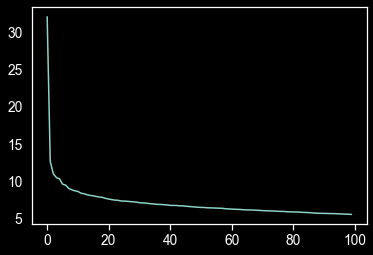

In [8]:
print(svd.explained_variance_ratio_.sum())
plt.plot(svd.singular_values_.tolist());

In [10]:
latent_factors = {}
for col in components.columns:
    # print(col, ":", components[col].sort_values(ascending=False).iloc[0:15].index.tolist())
    latent_factors[col]=components[col].sort_values(ascending=False).iloc[0:15].index.tolist()

# Only films with at least 1000 votes are shown
for el in reduced_tfidf.columns[0:15]:
    print(el, ":", latent_factors[el])
    display(reduced_tfidf.sort_values(by=[el], ascending=False).loc[:,["primaryTitle", el, "genres", "plot"]].iloc[:5])

LatentFactor1 : ['life', 'one', 'get', 'love', 'find', 'family', 'take', 'go', 'friend', 'young', 'year', 'make', 'new', 'woman', 'time']


,primaryTitle,LatentFactor1,genres,plot
20294,The Other Woman,0.356791,"Drama,Mystery,Romance",carlota cordelia physically identical inside complete opposite carlota grown world dominate mother bernada emotionally ab...
33837,Stairway from Hell,0.356205,Documentary,u never know true poverty poverty watch child die cannot afford hospital poverty try make enough money pick garbage hopef...
23144,When I Turned Nine,0.355069,Drama,life nine year old easy life yeomin mature thoughtful 9 year old boy life small mountain village even young age many thin...
48970,A Good Wife,0.347130,Romance,quarantine time make try different language end find search netflix first time saw taiwan wonderful good wife watch epi...
27186,Heaven's Doors,0.345669,Drama,casablanca late afternoon ney young man early 20 head toward victim apartment order get revenge act lead collision three ...


LatentFactor2 : ['father', 'son', 'get', 'mother', 'love', 'family', 'daughter', 'wife', 'married', 'find', 'brother', 'marry', 'husband', 'sister', 'fall']


,primaryTitle,LatentFactor2,genres,plot
15027,Aaj Ka Ye Ghar,0.272425,Drama,mala come wealthy family life palatial house dad businessman mother housewife young brother fall love middleclassed man n...
49725,Baba Keno Chakar,0.242945,Drama,rajnarayan baburajjak two son one daughter tuhinpijush ganguly tushar prosenjit chatterjee khushisreelekha mitra tuhin wi...
4479,Sharada,0.226081,"Drama,Musical,Romance",chiranjeev life wealthy lifestyle along widowed father kashiram two sister one dumb young brother trip friend mohan fall ...
18043,Jeevan Dhaara,0.221645,"Drama,Family",overwhelmed mr shrivastav unable shoulder responsibility raise look wife two daughter one son leaf home decides celibate ...
49536,Brother of Bommali,0.219213,"Action,Drama",naresh karthika brother sister karthika great fighter fight well well practise karate small age two grown naresh met girl...


LatentFactor3 : ['police', 'kill', 'murder', 'gang', 'killer', 'crime', 'detective', 'case', 'war', 'officer', 'town', 'agent', 'team', 'escape', 'criminal']


,primaryTitle,LatentFactor3,genres,plot
21086,Khakee,0.215488,"Action,Crime,Drama",dcp anant shrivastav amitabh bachchan assign mission escort terrorist iqbal ansari atul kulkarni chandangarh mumbai terro...
32236,Our Town,0.205278,"Crime,Mystery,Thriller",two killer living town ordinary small town terrorize local woman found brutally murder crucify public place gyeongjoo str...
22612,The Survivors Club,0.203699,"Crime,Drama,Thriller",rap serial killer jillian hayes carol rosen meg pesaturo found survivor club use press force police justice arrest rapist...
38426,The Outlaw,0.203524,"Crime,Mystery,Thriller",detective jungsoo face victim brutal murder kill reason make outrage investigation meet jihyun survivor marries cannot es...
50170,For Justice,0.202665,Drama,fbi agent natalia chapin anika noni rise justice department lawyer jess kinney shawn hatosy lead investigation justice de...


LatentFactor4 : ['di', 'la', 'un', 'il', 'de', 'una', 'che', 'per', 'si', 'con', 'le', 'del', 'que', 'en', 'da']


,primaryTitle,LatentFactor4,genres,plot
15686,Muzungu,0.766088,Comedy,eduardo detto dodò e freddi sono animatori di villaggi turistici africa durante un quantomeno avventuroso viaggio di tras...
4693,You're on Your Own,0.745117,Comedy,rom anni 50 dopo la seconda guerra mondiale cè penuria di alloggi ciò ha costretto la coabitazione uno stesso appartament...
4710,La cambiale,0.735304,Comedy,cugini posalaquaglia sono due piccoli truffatori e vivacchiano di espedienti dante ottiene come riconoscimento per tommas...
13477,L'ultima scena,0.733272,Comedy,la serum della prova generale di una modesta compagnia teatrale antonio capocomico e primo attore è assillato da una preo...
17639,Zora the Vampire,0.731715,"Comedy,Horror",transilvania anno 2000 affascinato dalle veline televisive italiane che riceve con la parabolica il conte dracula decide ...


LatentFactor5 : ['family', 'war', 'father', 'son', 'child', 'mother', 'world', 'life', 'year', 'daughter', 'village', 'death', 'brother', 'soldier', 'army']


,primaryTitle,LatentFactor5,genres,plot
29303,The Matriarch,0.237068,"Comedy,Drama",heart koppelo family worn number travel united strong family proud history share misfortune never stop believe gang vaga...
50799,I Declare War,0.225526,"Crime,Drama",declare war take heart city detroit sinclair family demarco family khalil family vie control power money love family fami...
22129,Catharsis,0.218577,Drama,naoki ono 14yearold boy murder young girl suburb tokyo result large family change name live apart naoki go reformatory to...
21881,Le fil cassé,0.209909,Documentary,poetic meditation passing time man explores family history declaration love mother michel langlois child end line last li...
38646,Two Lives,0.203131,"Drama,Thriller",europe 1990 berlin wall crumble katrine raise east germany living norway since 20 year war child result love relationship...


LatentFactor6 : ['school', 'student', 'high', 'boy', 'girl', 'father', 'teacher', 'family', 'friend', 'town', 'mother', 'team', 'child', 'parent', 'old']


,primaryTitle,LatentFactor6,genres,plot
30023,Crows Zero,0.362841,"Action,Comedy,Crime",suzuran senior high school boy nickname school crow poorest achieve violent school country student call crow band togethe...
37004,Maid Sama!,0.352623,"Animation,Comedy,Romance",seika high school boy school notorious wild student generally terrify place girl recently become coed school female popul...
47003,Nazo no tenkôsei,0.345020,Mystery,iwata koichi nakamura aoi kagawa midori sakurai minami secondyear student tozaiyama high school one day come home school ...
54867,Classroom of the Elite,0.328476,"Animation,Comedy,Romance",koudo ikusei senior high school lead prestigious school stateart facility nearly 100 student go university find employmen...
25232,And I Lived,0.324667,Drama,babylon high school look like normal high school suburban america student arrive school student body definite division mo...


LatentFactor7 : ['family', 'show', 'son', 'father', 'music', 'child', 'band', 'get', 'brother', 'mother', 'feature', 'daughter', 'include', 'interview', 'money']


,primaryTitle,LatentFactor7,genres,plot
28313,The Peasall Sisters: Family Harmony,0.237857,"Biography,Documentary,Music",life home school family six child change overnight record song grammy award win soundtrack brother art thou remain consta...
7796,Khatta Meetha,0.212569,"Comedy,Drama",homi mistry ashok kumar widower several year look four son small house job factory nargis sethna widowed housewife two so...
41043,Bread and Circuses,0.211839,Comedy,family novak small town velenje drawn lot participate tv family quiz mother daughter thrill appear tv whereas father son ...
21624,Myth of Father,0.199710,"Documentary,Drama",myth father video acceptance father jodie transsexual woman come year ago since begin journey discover father really upo...
51508,Family Therapy with Dr. Jenn,0.195990,Reality-TV,hollywood embattle family take feud vh1 reality ex dina michael lohan one five family show first season hop work issue t...


LatentFactor8 : ['love', 'war', 'fall', 'school', 'girl', 'get', 'king', 'army', 'marry', 'team', 'soldier', 'german', 'fight', 'married', 'meet']


,primaryTitle,LatentFactor8,genres,plot
29290,Param Vir Chakra,0.241887,War,three friend national defense academy fall love one girl pas officer indian defense service one becomes army officer seco...
49536,Brother of Bommali,0.238474,"Action,Drama",naresh karthika brother sister karthika great fighter fight well well practise karate small age two grown naresh met girl...
23863,The Tiger and the Snow,0.219744,"Comedy,Drama,Romance",love injury time war attilio de giovanni teach poetry italy romantic soul woman love love vittoria love unrequited every ...
9583,Moonzund,0.211497,"Drama,History,Romance",moonzund 1987 base eponymous book russian navy 19151917 wwi battle moonzund island baltic sea two drama intertwine world ...
18875,Ölmeyen sarki,0.203123,"Drama,Romance",semra famous singer daughter cigdem go conservatoire cigdem fall love new music teacher bulent piece music semra play cig...


LatentFactor9 : ['school', 'woman', 'police', 'student', 'murder', 'case', 'young', 'high', 'detective', 'killer', 'teacher', 'crime', 'kill', 'death', 'girl']


,primaryTitle,LatentFactor9,genres,plot
54867,Classroom of the Elite,0.251837,"Animation,Comedy,Romance",koudo ikusei senior high school lead prestigious school stateart facility nearly 100 student go university find employmen...
37004,Maid Sama!,0.243678,"Animation,Comedy,Romance",seika high school boy school notorious wild student generally terrify place girl recently become coed school female popul...
3758,Inside a Girls' Dormitory,0.239299,"Crime,Drama,Mystery",detective marco assign investigate murder occur exclusive boarding school adolescent girl victim popular wealthy girl fou...
29752,The Haunted School,0.235009,Horror,narranmoda boarding school strict girl rigid rule behavior headmaster accepts four male student improve income school how...
20522,Clase 406,0.232792,"Comedy,Crime,Drama",francisco romero smalltown teacher decides try luck mexico city join faculty prep school number 10 rosario castellanos so...


LatentFactor10 : ['woman', 'town', 'young', 'girl', 'music', 'band', 'father', 'old', 'new', 'boy', 'john', 'night', 'house', 'man', 'love']


,primaryTitle,LatentFactor10,genres,plot
13680,Caresses,0.169000,Drama,eleven episode portray different encounter large city course single night towards end millennium young man want stop livi...
15035,Cigarette Girl,0.156947,"Comedy,Music,Romance",boy meet girl boy tell girl oil company president tell popular night club singer boy girl tell little white lie via contr...
19744,Summer of Love,0.151051,"Drama,Romance",young couple share summer romance trio visit american artist love relationship nature art death meaning life set beautif...
36684,Music of Ireland: Welcome Home,0.150464,Documentary,music ireland welcome home tell definitive contemporary irish music focus emerald isle great musical export influence am...
4872,Las hijas del Amapolo,0.148593,"Comedy,Family,Musical",four charm sister living small town father grandmother sara garcia girl passing bad time father town governor want daugh...


LatentFactor11 : ['woman', 'child', 'one', 'show', 'day', 'house', 'mother', 'year', 'husband', 'go', 'see', 'village', 'night', 'three', 'contestant']


,primaryTitle,LatentFactor11,genres,plot
34971,Twins by Surprise,0.205988,Drama,woman thought go give birth one child actually give birth two meet woman desire home birth never ultrasound gain 25pounds...
18057,The Day I Became a Woman,0.181864,"Comedy,Drama",comprise three interconnect vignette depict woman three stage life iran first part center young girl ninth birthday told...
55043,Do Women Have a Higher Sex Drive?,0.179701,Documentary,year men underestimated woman year men thought smarter woman woman outnumber men college year men thought woman work woma...
23761,Moolaadé,0.178789,Drama,african village day six 49yearold girl cut act female genital mutilation child know operation horrible torture sometimes ...
19271,My Sister's Kids,0.170120,Family,erik lund professor child psychology sister husband go vacation left charge five child really feel since go able try skil...


LatentFactor12 : ['love', 'family', 'game', 'show', 'brother', 'one', 'team', 'girl', 'murder', 'killer', 'evil', 'contestant', 'world', 'earth', 'kill']


,primaryTitle,LatentFactor12,genres,plot
48918,Family Feud,0.203655,Game-Show,family feud family tv show age whole family enjoys family feud quiz show host asks one question team captain buzz say ans...
15164,Hot Potato,0.183376,"Family,Game-Show",two team three contestant something common eg beer taster mother compete host cullen read question multiple answer questi...
19071,To Tell the Truth,0.181576,Family,tell truth one mark goodson production durable format 1990 represent fourth revival popular game show format remain three...
15877,Trivia Trap,0.179305,Game-Show,shortlived game show use two format implement use celebrity attempt cash trivia game craze two threemember team junior wh...
21282,Couch Potatoes,0.174692,Game-Show,two team three player state sweet name regard television show past present eg jefferson spun family round contestant team...


LatentFactor13 : ['family', 'team', 'woman', 'game', 'new', 'husband', 'wife', 'war', 'relationship', 'love', 'friend', 'secret', 'jack', 'david', 'dr']


,primaryTitle,LatentFactor13,genres,plot
50799,I Declare War,0.233684,"Crime,Drama",declare war take heart city detroit sinclair family demarco family khalil family vie control power money love family fami...
48918,Family Feud,0.218317,Game-Show,family feud family tv show age whole family enjoys family feud quiz show host asks one question team captain buzz say ans...
48260,Irreplaceable,0.187897,Documentary,irreplaceable seek ask important question family family still matter today society host tim sisarich executive director ...
30183,Save Us from Our House,0.183501,"Family,Reality-TV",fast pace fun move halfhour relationshiprenovationreality tv house save trio relationship counselor contractor designer r...
45084,"Idainaru, Shurarabon",0.179126,Comedy,ryosuke hinode move relative hinode family locate ishibashi castle lake biwa enters high school hinode family posse speci...


LatentFactor14 : ['family', 'girl', 'woman', 'town', 'brother', 'two', 'young', 'gang', 'one', 'men', 'boy', 'small', 'village', 'war', 'show']


,primaryTitle,LatentFactor14,genres,plot
29303,The Matriarch,0.243602,"Comedy,Drama",heart koppelo family worn number travel united strong family proud history share misfortune never stop believe gang vaga...
50799,I Declare War,0.209064,"Crime,Drama",declare war take heart city detroit sinclair family demarco family khalil family vie control power money love family fami...
44128,Por Tu Culpa,0.202357,"Drama,Romance",two young brother know good look fun beach party end fall love girl one extravagant event though young brother meet beaut...
22129,Catharsis,0.202129,Drama,naoki ono 14yearold boy murder young girl suburb tokyo result large family change name live apart naoki go reformatory to...
4996,An Angel Has Appeared,0.199022,"Drama,Musical",marisol parent dead decides sell everything go madrid uncle ramon family leonor aunt bad woman like marisol treat one fam...


LatentFactor15 : ['father', 'team', 'woman', 'mother', 'game', 'life', 'de', 'young', 'man', 'son', 'world', 'player', 'money', 'boy', 'win']


,primaryTitle,LatentFactor15,genres,plot
35951,Hero,0.217848,Drama,little league coach joe finn whose pursuit fame fortune leaf little broken relationshipsparticularly son determine win ba...
31480,Stove League,0.200259,"Drama,Sport",preparation period major league baseball team drama focus loser team prepares extraordinary season upon arrival new gener...
15877,Trivia Trap,0.195092,Game-Show,shortlived game show use two format implement use celebrity attempt cash trivia game craze two threemember team junior wh...
15164,Hot Potato,0.193945,"Family,Game-Show",two team three contestant something common eg beer taster mother compete host cullen read question multiple answer questi...
27595,Woman Soccer Player #9,0.188519,Drama,soccer coach gao bo coach woman team japan brings back memory similar job china decides return china reorganize old team ...


The first dimension puzzles me. All movies rank positively in that dimension. I fail to see what it is about. It involves very common subjects and characters, since it mentions words like "family", "woman", "friend", "year", "new".

In [83]:
reduced_tfidf.groupby("main_genre").mean()

,LatentFactor1,LatentFactor2,LatentFactor3,LatentFactor4,LatentFactor5,LatentFactor6,LatentFactor7,LatentFactor8,LatentFactor9,LatentFactor10,...,LatentFactor92,LatentFactor93,LatentFactor94,LatentFactor95,LatentFactor96,LatentFactor97,LatentFactor98,LatentFactor99,LatentFactor100,numVotes
main_genre,,,,,,,,,,,,,,,,,,,,,
Action,0.119570,-0.003209,-0.040996,0.009747,0.003754,-0.004095,0.004493,0.011623,-0.006910,0.013063,...,0.000463,0.000866,0.001063,0.000567,-0.000298,0.000267,-0.000437,0.000035,-0.000601,18697.764893
Adult,0.117412,0.001181,-0.003829,-0.034368,-0.018648,-0.001374,-0.001366,0.003769,0.009180,-0.022362,...,-0.000229,0.011431,0.001798,-0.002113,0.004757,0.002023,-0.000588,0.007995,0.006184,119.916230
Adventure,0.119837,-0.011931,-0.012946,0.007832,0.010177,-0.006901,0.008413,0.011337,-0.020405,-0.010816,...,-0.000131,0.000011,-0.000997,0.000562,-0.001464,-0.000456,-0.001558,-0.000159,0.002179,15055.177650
Animation,0.120490,-0.021767,0.006369,-0.013754,0.025090,-0.010852,0.007872,0.007318,-0.011697,-0.010201,...,0.000184,0.000697,-0.002150,0.001606,-0.000438,-0.000754,-0.000236,-0.001717,0.001317,4655.689965
Biography,0.116449,-0.040083,0.019691,0.014776,-0.007264,0.013275,-0.001693,0.003757,0.014345,0.006581,...,0.002280,-0.001335,-0.002647,-0.001101,0.000643,0.000246,-0.002376,0.000154,-0.000029,10742.168502
Comedy,0.126759,0.008059,0.006369,-0.021935,-0.002951,0.008979,0.004621,0.001558,-0.005909,-0.001085,...,-0.002758,-0.000600,0.001542,-0.000721,0.000235,-0.000012,0.001488,-0.000255,-0.001120,7069.638759
Crime,0.125389,0.011869,-0.042278,-0.002317,-0.010271,0.004228,-0.003160,-0.018734,0.022679,0.017328,...,-0.000040,-0.000592,0.000822,0.000593,-0.001189,-0.000438,0.000526,-0.001663,-0.000842,12366.686020
Documentary,0.111102,-0.063180,0.016943,0.016702,-0.002209,0.013383,-0.004652,0.002365,0.010307,-0.000841,...,0.001925,0.001755,0.000107,0.000460,0.000049,-0.000140,-0.001257,0.001162,0.000866,350.326496
Drama,0.135079,0.016337,0.011348,0.007595,-0.002674,-0.002372,0.004104,0.000204,0.003299,-0.000703,...,0.000029,-0.000724,-0.000169,0.000627,-0.000496,-0.000978,0.000426,-0.000501,-0.000082,5639.290746


What about recommendations ?

In [106]:
# This function is poorly programmed
# It needs an IMDb tconst as an input, and outputs the 9 most similar films.
def similar_films(tconst):
    film_query = reduced_tfidf.loc[reduced_tfidf["tconst"]==tconst]

    #It's a simple computation of the cosine similarity between the film queried, and all other films in the (reduced) dataset
    cosine_similarity=pd.DataFrame(
        metrics.pairwise.cosine_similarity(
            film_query.iloc[:,0:100].to_numpy().reshape(1,-1),
            reduced_tfidf.iloc[:,0:100].to_numpy())
    ).transpose().rename(columns={0:"Similarity"})

    return pd.concat([
        cosine_similarity,
        reduced_tfidf.loc[:,["primaryTitle", "genres", "plot"]]
    ], axis=1).sort_values(by="Similarity", ascending=False).iloc[0:10]

Love Exposure is a weird four-hour film by Sion Sono. It's about... a lot of things. In a nutshell, it's a kid who decides to sin to please his father, a priest, by taking panty shots. One day, while crossdressing, he falls in love with some girl--whom he names Maria--and gets tangled up with some religious cult. And stuff happens and at some point there's a 5 mn monologue about Corinthians 13, with Beethoven in the background. It's actually quite good.

The other films seem to be about teenage love, a "catholic priest", a dead mom... But that's about it for the similarities.

In [107]:
similar_films("tt1128075")

,Similarity,primaryTitle,genres,plot
31363,1.000000,Love Exposure,"Action,Comedy,Drama",three emotionally abuse people fringe society get lock convolute love triangle yuu catholic boy search true love end take...
18914,0.655281,A Touch of Fate,Drama,one night small town north carolina fate brings together three life entertainment lawyer return home die mother year esca...
16128,0.637921,Vsichko e lyubov,Drama,boy poor sofia neighborhood rado orphan commit several petty crime sent borstal put otherwise becomes juvenile prisoner u...
27224,0.635736,Rasathanthram,"Comedy,Drama,Family",premachandran good carpenter wellversed thachushastra science carpentry sought many true profession painful past shun res...
23700,0.628316,Inocente de ti,Romance,city zacatecas florecita take large trip united state company sister isela grandmother cleotilde girl go reunite father r...
44412,0.627999,Muj vysvlecenej denik,"Comedy,Drama,Romance",bittersweet teenage comedy base upon bestselling novel write seventeen year old girl johana rubinova johana veronika kuba...
16165,0.621296,El cielo y tu,Drama,father mauro catholic priest social worker whose main goal fight drug use juvenile delinquency attack servant wealthy man...
18763,0.613803,Heroes in Love,"Drama,Romance,Thriller",separate three different short kidnap focus tomboy unrequited love anonymous girl dare speak name watch longing object a...
5091,0.609422,Love at Twenty,"Drama,Romance",love twenty unites five director around world present different perspective love really age 20 episode united score georg...
5377,0.605115,Swedish Wedding Night,Drama,wedding without love bridegroom owner great butcher enterprise town also womaniser boast know kind pant numerous girl wea...


That's the 2019 Korean film by Bong Joon-Ho that won the Golden palm. It's very interesting that The Housemaid ranks so high. I admit I barely remember it, but I don't find the comparison shocking.

In [86]:
similar_films("tt6751668")

,Similarity,primaryTitle,genres,plot
74835,1.000000,Parasite,"Comedy,Drama,Thriller",kims mother father chungsook kitaek young adult offspring son kiwoo daughter kijung poor family living shabby cramped hal...
20348,0.711410,The Housemaid,"Crime,Drama,Thriller",60 korea piano teacher mr kim work factory give music class worker receives love letter student miss kwak delivers letter...
19313,0.709190,Shadow Zone: My Teacher Ate My Homework,"Comedy,Horror",thirteenyearold jesse typical teenager hate teacher mr fink visit vintage clothing shop jesse see doll look exactly like ...
27150,0.700712,Troublesome Night 9,"Comedy,Horror",liu ah yee go bud household worship buddha fortune told mr bud tell necessary m liu compulsive gambler cruise ship neptun...
38860,0.694686,The Obsession,Thriller,deborah matthew divorce husband jason matthew finalize file divorce believe cheat jason since move away work often commun...
8674,0.693607,"Mrs. Brown, You've Got a Lovely Daughter","Comedy,Musical",friend herman karl keith derek barry work class manchester lad get far respective work life fact epitomize herman failure...
38637,0.682475,Bright Star,"Biography,Drama,Romance",1818 hampstead village outskirt london poet charles brown life one half house dilkes family live half association dilkes ...
63008,0.675692,Two Down,"Comedy,Crime,Thriller",two first theatrical feature fizz ginger screen international uk picked star tomorrow edition 2013 set modern day london...
57327,0.674477,The Soul of Bread,"Comedy,Romance",gaobing work bakery small town owner mr chiu rock n roll band apprentice di seem enthusiastic learn baking business baker...
1671,0.670397,Mr. Cohen Takes a Walk,Drama,mr cohen father own large department store london care good shopkeeper good person mr cohen elder son friend son work sl...


The Thing is a well-known horror film by John Carpenter about the [worst kind of alien](https://www.youtube.com/watch?v=NtgFKdWcKXY). We do capture the fact that the movie is about an alien. However it's mixed with movies that are well outside the horror genre.

In [177]:
similar_films("tt0084787")

,Similarity,primaryTitle,genres,plot
8552,1.000000,The Thing,"Horror,Mystery,Sci-Fi",u research station antarctica earlywinter 1982 base suddenly buzz helicopter nearby norwegian research station try kill d...
23783,0.723264,Aliens of the Deep,"Documentary,Family",james cameron journey earth deepest extreme unknown environment search strange alien creature live join team young nasa s...
35509,0.716416,Monsters vs Aliens: Mutant Pumpkins from Outer Space,"Animation,Comedy,Family",susan murphy k ginormica monster work u government special ops alien presence detect susan hometown modesto california ri...
25273,0.709571,Alien Planet,"Adventure,Animation,Documentary",cgi computer animate dramadocumentary take place darwin iv planet 65 light year earth 2 sun 60 earth gravity identify dar...
9079,0.686315,Lifeforce,"Action,Horror,Mystery",space shuttle churchill assign observe halley comet command colonel tom carlsen see strange form attach comet carlsen go ...
48495,0.680038,Halo: Nightfall,"Action,Adventure,Family",26th century prolong war humanity fanatical alien alliance covenant end tenuous treaty despite ceasefire earth outer colo...
6530,0.678209,The Andromeda Strain,"Mystery,Sci-Fi,Thriller",virtually resident piedmont new mexico found dead return earth space satellite head u air force project scoop declares em...
5487,0.677527,The Time Travelers,Sci-Fi,1964 team scientist try develop view screen future fact get portal soon find side 127 year future portal collapse earth f...
36503,0.675383,Misión en Mocland - Una aventura super espacial,"Adventure,Animation,Sci-Fi",planet moc límbar equivalent water vital substance general neflin steal límbar get power planet queen pola send special t...
8305,0.672358,Galaxy of Terror,"Action,Adventure,Horror",spacecraft travel distant planet rescue crew another spaceship crashed craft damage land need repair baelon command rescu...


Oldboy is one of those typical Korean revenge movies. A guy gets kidnapped and locked up in a hotel room for 20 years. After being released, he tries to find his abductor.

I'm not sure if the other films are really similar ? Well, Misdirected is about a movie, at the very least. It's quite disappointing, there are a lot of Korean movies about revenge that were inspired from Oldboy (and the movie is actually part of a series of similar films). Too bad.

In [75]:
similar_films("tt0364569")

,Similarity,primaryTitle,genres,plot
18249,1.000000,Oldboy,"Action,Drama,Mystery",abduct rainy night 1988 obnoxious drunk oh daesu much surprise wake lock windowless dilapidate hotel room unknown reason ...
44193,0.673721,Monsters,Horror,jia ying sale manager real estate mean indifferent still remains single never expect something like would happen customer...
23517,0.632504,Pink Lemonade,Comedy,ever one night nothing seem go right ever job make ponder place would fun suck much welcome foodservice hell natalie wait...
21690,0.623632,Misdirected,Comedy,would woke motel room gun hand corpse bed memory happen night scenario impose upon stuart hapless college student whose l...
19965,0.616814,The Man from London,"Crime,Drama,Mystery",one night maloin switchman seaside railway station situate ferry harbor witness terrible event watch arrival last ferry n...
6733,0.606601,Aakrosh,"Crime,Drama,Music",work mentor public prosecutor dushane many year advocate bhaskar kulkarni assign legal aid case bhiku lahanya accuse brut...
33968,0.597778,The Body,"Mystery,Thriller",middle night guard work night shift morgue locate deep wood terrible car accident guard panic left post first place furth...
10197,0.596933,Red Lips II,Horror,ok debbie rochon make real cheapies road title scream queen definitely low budget absolutely nothing spent extra hey get ...
21120,0.594486,Bir erkegin anatomisi,Drama,taner upscale successful istanbul lawyer somewhat unhappy private life one day take trial underground guy give file full ...
39430,0.593836,Joogoonui Taeyang,"Comedy,Fantasy,Horror",suffer accident year ago tae gong shil gain ability see talk ghost however year later still scare constant demand help ma...


Cross of Iron is a movie by Sam Peckinpah about WWII. This one works really well. The dimensionality reduction really managed to capture the topics about war.

In [87]:
similar_films("tt0074695")

,Similarity,primaryTitle,genres,plot
10639,1.000000,Cross of Iron,"Drama,War",1943 russian front decorate leader rolf steiner promote sergeant another successful mission meanwhile upperclass arrogant...
8193,0.816709,Lost Command,"Action,Drama,War",1954 final day french military involvement indochina french army colonel pierrenoel raspeguy lead paratrooper decisive ba...
8447,0.786825,Japan's Longest Day,"Drama,History,War",follow detonation atomic bomb hiroshima nagasaki japanese military government clash demand ally unconditional surrender m...
9429,0.761283,Sergeant Klems,"Action,Adventure,Romance",final day world war one german army deserter steal identity dead german soldier new name otto josef klems war join french...
9251,0.749158,Many Wars Ago,"Drama,War",northern italy wwi turn bloody stalemate bogged trench barren highland men italian infantry division give one objective r...
18582,0.730160,Sharpe's Waterloo,"Action,Adventure,Drama",base novel bernard cornwell sharpe waterloo brings maverick british officer lt col richard sharpe last fight french june ...
75630,0.726758,Eternal Wave,"Action,Drama",year 1930 shanghai know paris east thrive economy however behind glamorous song dance cruelty terror get control marco po...
69644,0.721030,Railroad Tigers,"Action,Adventure,Comedy",december 1941 railway tianjin nanjing east china become key military transportation route heavily guard japanese soldier ...
45642,0.713837,Fighting for the Motherland,"Action,History",1161 wanyan liang emperor jurchen jin dynasty plan invade southern song dynasty owe harsh recruitment policy jin cruelty ...
6272,0.713084,The Guns of Fort Petticoat,"Action,Romance,War",lt frank hewitt desert union army warn former texas neighbor impend indian attack trigger army massacre overcomes initial...


I want to visualize a few of these latent dimensions.

Silhouette scores: {2: 0.25725474870359494, 3: 0.2718206034263694, 4: 0.2551204511417464, 5: 0.24377058401787058, 6: 0.23243780244062826, 7: 0.23927082295783988, 8: 0.23343142572065922, 9: 0.23411885535390586}


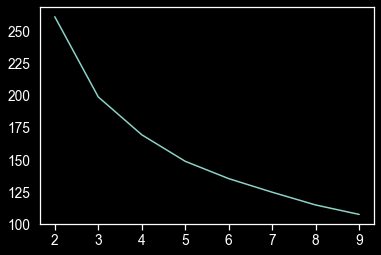

In [166]:
inertias = {}
silhouette = {}
for k in range(2,10):
    km = KMeans(n_clusters=k)
    km.fit(reduced_tfidf.loc[:,["LatentFactor2", "LatentFactor3", "LatentFactor8"]])
    inertias[k]=km.inertia_
    silhouette[k] = metrics.silhouette_score(reduced_tfidf.loc[:,["LatentFactor2", "LatentFactor3", "LatentFactor8"]], km.labels_, metric='euclidean')

plt.plot(list(inertias.keys()), list(inertias.values()))
print("Silhouette scores:", silhouette)

Interestingly, the dimensions used here (2, 3, 8) are quite easy to interpret. I named them, respectively: Family Drama, Crime, and War/Historical.

A few films that rank high on War/Historical: Apocalypse Now, 300, Inglorious Basterds, and... Shrek. Probably because there are the words "king" and "princess" in the plot; other words that are common in this dimension are "german", "war", "army", "soldier", "fight" (hence the name). War/Historical films seem to also rate high on Crime (except Shrek), surely because of the words like "kill", "agents", "teams"...

This clustering seems useless to me. It just looks a bit nice. If I had to do this myself, I would have a specific cluster for observations at the center, since they don't rank high on any particular axis (e.g. Mad Max Fury Road, Donnie Darko, Star Trek, Star Wars, or those Marvel movies)

In [174]:
km=KMeans(n_clusters=3)
reduced_tfidf["clusters"]=km.fit_predict(reduced_tfidf.loc[:,["LatentFactor2","LatentFactor3", "LatentFactor8"]])

px.scatter_3d(
    data_frame=reduced_tfidf.assign(
        clusters=reduced_tfidf["clusters"].astype("category"),
        plot=reduced_tfidf["plot"].str.wrap(50).str.replace("\n", "<br>")
    ).rename(columns={
        "LatentFactor2": "LF2 Family Drama",
        "LatentFactor3": "LF3 Crime",
        "LatentFactor8": "LF8 War/Historic"
    }).loc[lambda x: x["numVotes"]>500000],
    x="LF2 Family Drama",
    y="LF3 Crime",
    z="LF8 War/Historic",
    color="clusters",
    color_discrete_sequence=px.colors.qualitative.Prism,
    hover_data=["primaryTitle", "plot"]
)

---
## LDA
---

I'm doing yet again the same thing as before, but with LDA. This time, I decided to keep all words however (excepts a few words in other languages or that I just didn't really find useful).

In [7]:
# Now would be a good time to free up some RAM if you have launched the previous analyses.
if 'tfidf_matrix' in locals():
    del tfidf_matrix
if 'reduced_tfidf' in locals():
    del reduced_tfidf
if 'components' in locals():
    del components

#### Setup

I'll loop through a range of number of topics to find the optimal set with a [coherence score](https://radimrehurek.com/gensim/models/coherencemodel.html).

In [50]:
# Parameters
min_nwords_corpus = 1 # I'll still keep documents with a description that is not TOO small
lda_ntopics = [5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 50]

df_desc_filtered = df_desc.assign(
    # I'm going to delete even more words. Verbs that I don't find very informative. And words from other languages
    plot=df_desc["plot"].str.replace(
        r"\b(?:{})\b".format(
            "|".join(["get", "become", "go", "look", "like", "see", "life", "one", "two", "three", "first", "second", "third",
            "en", "los", "las", "le", "la", "de", "el", "du", "des", "take", "que", "must", "have", "un",
            "da", 'di', "con", "al", "del", "una", "se", "il", "elle", "ne"])
        ),
        "",
        regex=True,
    )
).loc[(df_desc["plot"].str.split().apply(len) >= min_nwords_corpus)]
print(len(df_desc_filtered), "documents with descriptions >=", min_nwords_corpus, "words")

# Count vectorizer
CVectorizer = CountVectorizer()
CV_plot = CVectorizer.fit_transform(
    df_desc_filtered["plot"]
)
CV_plot_words = CVectorizer.get_feature_names()

# Gensim needs to convert dense and sparse Numpy matrices before use
gensim_corpus = gensim.matutils.Sparse2Corpus(CV_plot, documents_columns=False)
# It also needs some specific dictionary for calculating Coherence. Really?
gensim_dict = gensim.corpora.Dictionary.from_corpus(
    gensim.matutils.Sparse2Corpus(CV_plot, documents_columns=False),
    id2word={k: v for k,v in enumerate(CV_plot_words)}
)

# Number of words
print("N words:", len(gensim_dict))

304416 documents with descriptions >= 1 words
N words: 262475


#### Coherence tuning
<div>
<img src="https://www.opnminded.com/wp-content/uploads/2013/10/tuning-style.jpg" width="200"/>
</div>



I looped through multiple numbers of topics, and kept the coherence value for each. Coherence values are based on this paper (which I haven't read): [http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). There are also [other parameters I should change](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0), but that would take too long.

11 topics seem to be marginally better. Hopefully, the randomness of LDA won't change this too much.

In [51]:
coherence_results = {
    'num_topics': lda_ntopics,
    'c_v': []
}

for lda_ntopics_val in lda_ntopics:
    print("N topics:", lda_ntopics_val)
    # Note: 
    # This is the Multicore version. You need to specify your number of physical cores minus one, in "workers".
    lda = gensim.models.LdaMulticore(
        corpus=gensim_corpus,
        id2word=gensim_dict,
        workers=psutil.cpu_count(logical=False)-1,
        num_topics=lda_ntopics_val,
        random_state=451
    )

    coherence_value = gensim.models.CoherenceModel(model=lda, texts=df_desc_filtered["plot"].str.split(), corpus=gensim_corpus, coherence="c_v").get_coherence()
    print("C_v value:", coherence_value)
    coherence_results["c_v"].append(coherence_value)

N topics: 5
C_v value: 0.44236826170005444
N topics: 6
C_v value: 0.467162961560958
N topics: 7
C_v value: 0.46136212212883704
N topics: 8
C_v value: 0.45885832328375487
N topics: 9
C_v value: 0.44938716560824776
N topics: 10
C_v value: 0.44710446433195317
N topics: 11
C_v value: 0.47668932139452536
N topics: 12
C_v value: 0.4553332480658616
N topics: 15
C_v value: 0.45237197527335005
N topics: 20
C_v value: 0.4496445064544611
N topics: 30
C_v value: 0.43699781804082743
N topics: 50
C_v value: 0.41211918662360314


In [52]:
pd.DataFrame(coherence_results).sort_values(by="c_v", ascending=False)

,num_topics,c_v
6,11,0.476689
1,6,0.467163
2,7,0.461362
3,8,0.458858
7,12,0.455333
8,15,0.452372
9,20,0.449645
4,9,0.449387
5,10,0.447104
0,5,0.442368


In [53]:
# The optimal number of topics is automatically set using the table above, no need to change anything
lda_ntopics_val = pd.DataFrame(coherence_results).sort_values(by="c_v", ascending=False).iloc[0,0]

lda = gensim.models.LdaMulticore(
    corpus=gensim_corpus,
    id2word=gensim_dict,
    workers=psutil.cpu_count(logical=False)-1,
    num_topics=lda_ntopics_val,
    random_state=451
)

I'll do the analysis of the topics a bit further down

In [54]:
topics = lda.show_topics(num_topics=lda_ntopics_val, num_words=20, formatted=False)

# Some modifications to the list of topics, so it can be easily read
# It's just boring tuple/list manipulation
## Loop through topics
for i in range(len(topics)):
    # Change topic from tuple to list
    topics[i] = list(topics[i])
    # Rename titles from "[number]" to "Topic[number]"
    topics[i][0] = "Topic"+str(i)
    ## Loop through word_probabilities in each topic
    for j in range(len(topics[i][1])):
        # Change word_probability tuple to list
        topics[i][1][j]=list(topics[i][1][j])
        #Change to percentage
        topics[i][1][j][1]=str(round(topics[i][1][j][1]*100, 2))+"%"

for topic in topics:
    print(topic[0])
    print([word_prob for word_prob in topic[1]])

Topic0
[['world', '0.78%'], ['young', '0.51%'], ['man', '0.5%'], ['town', '0.43%'], ['power', '0.42%'], ['people', '0.4%'], ['find', '0.38%'], ['group', '0.38%'], ['year', '0.37%'], ['evil', '0.36%'], ['woman', '0.36%'], ['force', '0.34%'], ['search', '0.34%'], ['know', '0.34%'], ['time', '0.34%'], ['fight', '0.32%'], ['come', '0.31%'], ['new', '0.31%'], ['journey', '0.31%'], ['earth', '0.3%']]
Topic1
[['family', '1.07%'], ['young', '1.01%'], ['love', '0.89%'], ['mother', '0.81%'], ['girl', '0.78%'], ['school', '0.78%'], ['friend', '0.75%'], ['woman', '0.75%'], ['year', '0.74%'], ['find', '0.73%'], ['father', '0.7%'], ['old', '0.68%'], ['student', '0.6%'], ['home', '0.54%'], ['house', '0.54%'], ['man', '0.53%'], ['day', '0.52%'], ['new', '0.48%'], ['time', '0.46%'], ['try', '0.44%']]
Topic2
[['love', '1.3%'], ['family', '0.55%'], ['fall', '0.55%'], ['new', '0.5%'], ['young', '0.44%'], ['time', '0.41%'], ['girl', '0.38%'], ['find', '0.37%'], ['woman', '0.3%'], ['meet', '0.28%'], ['danie

In [42]:
# It's poor practice, but I left that at the end. Cherry on the top. That package looks rad.
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[Overview of what pyLDAvis does](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb)



In [55]:
pyLDAvis.display(gensimvis.prepare(lda, gensim_corpus, gensim_dict))

c:\Users\Didi\AppData\Local\Programs\PythonVenv\imdb\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


# Discussion/Conclusion

Choosing between these different clustering methods will prove rather difficult. Each has managed to capture main topics from the plot descriptions. Overall, the latent dimensions found by KMeans, LSA and LDA are rather similar.

We may also ask ourselves if those topics are really relevant, considering we already have information about the genres of films. While do capture latent dimensions that fall clearly within some genres (namely, crime movies and war movies), we also get some nuance that we don't find in the genres variables: content about school, teen movies, vampires, and (way too much) information about relationships, family, and others. Plus, with LDA and LSA, we get quantitative measures, instead of categorical variables.

It remains to be seen how useful these latent dimensions prove to be in other applications, such as regression or classification. This will probably be the correct way to assess which of these clusters/topics is the "best". I wanted to do some analyses on the awards variable, and see which between KMeans, LSA and LDA yield the best clusters/topics to predict whether a film will win an award or not (along with other covariates). 

A lot more cleaning could have been done on the descriptions of the films. There are still plots in other languages, which should be deleted ([this package](https://pypi.org/project/langdetect/) could have help). Also, the embeddings can be done a lot better (using bigrams and/or trigrams, for example)

# Appendix

## Graph PowerPoint

Some graph I made for a PowerPoint presentation. It's the number of movies produced per year.

In [5]:
df = pd.read_table(
    os.path.join("Data", "Raw", "title.basics.tsv"), low_memory=False, na_values="\\N"
).loc[lambda x: (x["titleType"]=="movie") & (x["startYear"] < 2022), ["tconst", "startYear", "primaryTitle"]]

In [ ]:
## YEAR

# Get weighted mean rating by year
groupby=df.groupby("startYear").agg(        
    Count=("tconst", "count")
).reset_index()

# Init
fig = go.Figure()

# Count line
fig.add_trace(go.Scatter(
    name="Count",
    x=groupby["startYear"],
    y=groupby["Count"],
    line_color='rgba(245,197,24,1)',
    showlegend=False
))

#Major films
fig.add_annotation(x=1921, y=groupby.loc[groupby["startYear"]==1921]["Count"].values[0],
            text=f"The Kid, Chaplin (8.3/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1972, y=groupby.loc[groupby["startYear"]==1972]["Count"].values[0],
            text=f"The Godfather, Coppola (9.2/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=1994, y=groupby.loc[groupby["startYear"]==1994]["Count"].values[0],
            text=f"The Shawshank Redemption, Darabont (9.3/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)
fig.add_annotation(x=2019, y=groupby.loc[groupby["startYear"]==2019]["Count"].values[0],
            text=f"Parasite, Bong Joon-ho (8.6/10)",
            opacity=0.8,
            showarrow=True,
            arrowhead=1)

fig.update_layout(hovermode="x")
fig.write_image("img/figPPTX.svg", width=1920, height=1080)
fig.show()